Check also https://www.authorea.com/users/173169/articles/208172-october-25-2017-summary-of-individual-fish-stochastic-swimming-model-and-fitting-results

Check coordinate system.

In [105]:
%matplotlib inline
import numpy as np
import dill as pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import sys
sys.path.append('../')
from numba import jit

from scipy.optimize import minimize, least_squares, curve_fit
from scipy.integrate import quad
from scipy.stats import spearmanr
from sklearn.mixture import GaussianMixture
from calovi import WallModel, SocialModel, KickModel

import sklearn.model_selection as cv
np.set_printoptions(suppress=True)

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


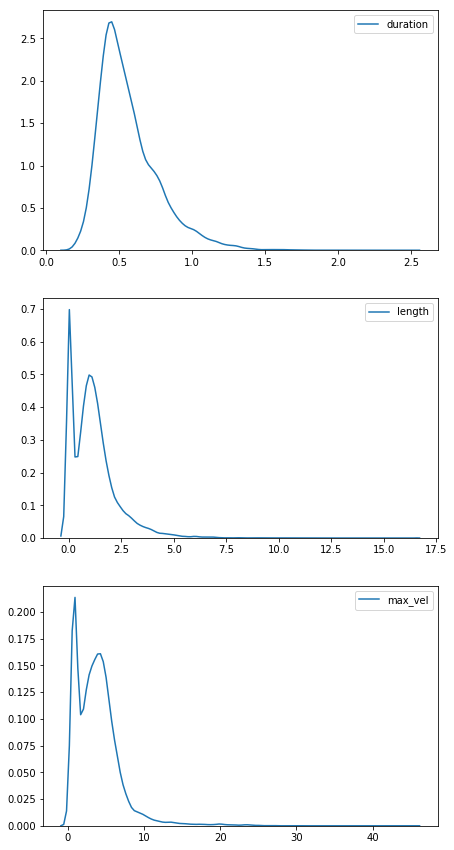

In [106]:
df = pd.read_csv("../../data/processed/kicks_guy.csv")
train, test = cv.train_test_split(df, train_size=0.8)
# TODO: Move to other notebook
fig, ax = plt.subplots(3, figsize=(5*2**(0.5), 3*5))
sns.kdeplot(df['duration'],ax=ax[0])
sns.kdeplot(df['length'], ax=ax[1])
sns.kdeplot(df['max_vel'], ax=ax[2])

fig.savefig('../../figures/kick_plots.pdf')
def fit_mixture(df, column, n_components=2):
    var = df[column].values.reshape(-1, 1)
    mix = GaussianMixture(n_components=n_components)
    mix.fit(var)
    return mix

# Create models for duration, length, max_velocity that we can sample from
duration_gmm = fit_mixture(df, 'duration')
length_gmm = fit_mixture(df, 'length')
max_vel_gmm = fit_mixture(df, 'max_vel')

In [107]:
len(train), len(test), len(df)

(19386, 4847, 24233)

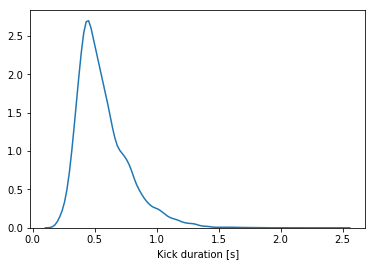

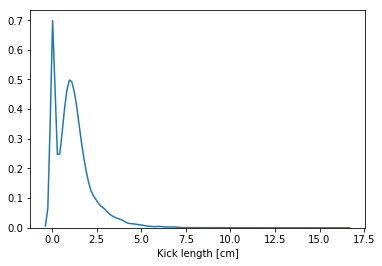

In [108]:
fig, ax = plt.subplots()
sns.kdeplot(df['duration'],ax=ax)
ax.legend_.remove()
ax.set_xlabel("Kick duration [s]")
fig.savefig('../../figures/kick_duration.pdf', transparent=True, bbox_inches='tight')

fig, ax = plt.subplots()
sns.kdeplot(df['length'],ax=ax)
ax.legend_.remove()
ax.set_xlabel("Kick length [cm]")
fig.savefig('../../figures/kick_length.pdf', transparent=True, bbox_inches='tight')

1.06472459564
0.8996720138193108


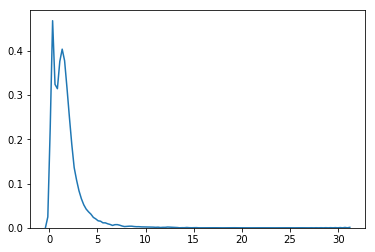

In [109]:
# Quick hack to find velocity decay parameter!
x0 = np.array([0.10])
max_vel = df['max_vel'].values
end_vel = df['end_vel'].values
length = df['length']
duration = df['duration'].values
vel_ratio = end_vel/max_vel
#decay = lambda time, decay_time: np.exp(-time/decay_time)
decay = lambda time, decay_time: np.exp(-time * decay_time)
res = curve_fit(decay, xdata=duration, ydata=vel_ratio, p0=x0)
velocity_decay_time = res[0][0]
print(velocity_decay_time)
# Check approximation of length by Calovis exponential decay model
length_hat = max_vel * velocity_decay_time * \
            (1 - np.exp(-duration/res[0]))
print(np.mean((length -  length_hat)**2))
sns.kdeplot(length_hat)

In [110]:
kick_model = KickModel(max_vel_gmm, duration_gmm, velocity_decay_time)
with open('../calovi_kick.model', 'wb') as f:
    pickle.dump(kick_model, f)
kick_model.get_peak_speed(), kick_model.get_kick_duration(), kick_model.get_velocity_decay_time()

(3.8579413391637152, 0.85070491998561026, 1.0647245956415241)

In [111]:
# Find average heading change without wall influence.
threshold = 10.0 # cm
condition = (df['wall_distance0_f0'] > threshold) & (df['wall_distance1_f0'] > threshold) & \
            (df['wall_distance2_f0'] > threshold) & (df['wall_distance3_f0'] > threshold)
    
print(f"We're considering {len(df[condition])} rows.")
free_heading = df[condition]['heading_change']
(np.array([free_heading.std(), free_heading.mean()]))

We're considering 199 rows.


array([ 1.06028333,  0.05899817])

In [112]:
#df = df.drop(df[df['neighbor_distance'] < 10].index) # No kicks where fish are close
#df = df.drop(df[df['geometric_leader'] != 'f0'].index) 
#df = df.drop(df[df['fish_id'] != 'f0'].index)

df.index = np.arange(0, len(df))
#df.index = np.arange(0, len(df))
df.describe()

,heading_change,duration,gliding_duration,length,max_vel,end_vel,neighbor_distance,neighbor_angle,viewing_angle_ltf,viewing_angle_ftl,...,wall_angle2_f0,wall_angle3_f0,wall_distance0_f1,wall_distance1_f1,wall_distance2_f1,wall_distance3_f1,wall_angle0_f1,wall_angle1_f1,wall_angle2_f1,wall_angle3_f1
count,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,...,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000,24233.000000
mean,0.026733,0.566026,0.286244,1.175548,3.874703,2.142558,6.712990,0.127936,-0.080550,0.047440,...,0.139550,0.025012,15.863073,15.463413,13.490759,14.362021,0.109828,-0.011711,0.153517,0.006569
std,1.339777,0.205481,0.140032,1.097354,3.059453,2.332805,9.207389,1.821645,2.214935,1.281680,...,1.794209,1.828171,10.374040,10.516186,10.374745,10.515198,1.820417,1.811876,1.798905,1.829177
min,-3.141544,0.180000,0.010000,0.000063,0.174125,-33.799212,0.340065,-3.141485,-3.141534,-3.126623,...,-3.141593,-3.141593,0.009460,0.004208,0.056511,0.382050,-3.141593,-3.141593,-3.141593,-3.141593
25%,-0.450296,0.420000,0.200000,0.383803,1.614709,0.533743,1.877623,-1.344399,-2.265842,-0.877393,...,-1.424708,-1.683914,5.272573,4.315849,2.789402,3.440970,-1.475022,-1.673524,-1.409096,-1.709747
50%,0.030694,0.520000,0.250000,1.014211,3.542443,1.150104,2.536399,-0.000398,-0.566979,0.101922,...,0.030646,0.035076,16.682517,16.309141,12.673159,13.494284,-0.044349,-0.015149,0.040172,0.015869
75%,0.554401,0.670000,0.320000,1.592560,5.131003,3.273658,4.433024,1.800399,2.175604,0.951638,...,1.672199,1.498168,26.581687,26.371443,24.101317,25.523198,1.690137,1.412613,1.708316,1.485876
max,3.141254,2.480000,1.830000,16.319537,45.074017,41.444344,37.606898,3.141536,3.141531,3.123267,...,3.141466,3.141550,29.356757,29.410165,29.413789,29.860656,3.141493,3.141442,3.141304,3.141322


In [113]:
# Try grad.desc as a sanity check
def calc_wall_error(model, xdata, ydata, params=None):
    lambda_reg = 0.0
    return np.linalg.norm(model(xdata) - ydata)/(len(ydata))

#fCur = lambda dist: f(dist, 1.9)
#OCur = lambda angle: O(angle, 0.8, 0.0)
#calc_wall_error(heading_change, wall_distance0, wall_angle0, fCur, OCur)

def compute_r2(x, y, model=None, yhat=None):
    if yhat is None:
        yhat = model(x)
    residuals = y - yhat
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    return 1 - (ss_res/ss_tot)

In [120]:
def get_data_wall(data):  
    heading_change = data['heading_change'].values
    wall_distance = np.vstack([data[f'wall_distance{i}_f0'].values for i in range(4)])
    wall_angle = np.vstack([data[f'wall_angle{i}_f0'].values for i in range(4)])
    xdata_wall = np.vstack((wall_distance, wall_angle))
    ydata = heading_change

    return xdata_wall, ydata

def fit_wall(data):
    # Setup data.   
    xdata_wall, ydata = get_data_wall(train)   

    # Initialise model with standard parameters.
    angular_model = 'calovi'
    wall_model = WallModel(angular_model)
    angular = WallModel.angular_map
    init_x = WallModel.params_map

    # Setup helper methods and bounds for optimizer.
    x0 = init_x[angular_model]
    #x0[1] = 15

    l_bounds = np.array([-np.inf] * len(x0))
    u_bounds = np.array([ np.inf] * len(x0))

    #l_bounds[1] = 0.0 # no negative decay
    #u_bounds[1] = 20
    bounds = (l_bounds, u_bounds)

    # Fit the model
    res = curve_fit(wall_model.evaluate_raw, xdata=xdata_wall, ydata=ydata, p0=x0, bounds=bounds)#,max_nfev=1000000)
    x_opt_wall = res[0]
    
    wall_model.set_params(x_opt_wall)
    return wall_model, x0, x_opt_wall

wall_model, x0, x_opt_wall = fit_wall(train)

# Evaluate the model for both datasets
def evaluate_model(data, wall_model, x0, x_opt_wall):
    xdata_wall, ydata = get_data_wall(data)
    fitted_model = lambda xdata: wall_model.evaluate_raw(xdata, *x_opt_wall)
    random_model = lambda xdata: wall_model.evaluate_raw(xdata, *x0)
    mean_model = lambda xdata: np.ones_like(xdata) * np.mean(ydata)

    print(f"Curve fit reached error of {calc_wall_error(fitted_model, xdata_wall, ydata, x_opt_wall)} with params={str(x_opt_wall)}")
    print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
    print(f"Random params reached error of {calc_wall_error(random_model, xdata_wall, ydata, x0)} with params={x0}")

    # Calculate error for mean heading change as model
    mean_heading_error = calc_wall_error(mean_model, xdata_wall, ydata, np.array([0.0]))
    print(f"Predicting the average heading {np.mean(ydata)} for each heading leads to an error of {mean_heading_error}")

    print(f"Model has r^2 of {compute_r2(xdata_wall, ydata, fitted_model)}")
    yHat = fitted_model(xdata_wall)
    print(f"Correlation={np.corrcoef(ydata, yHat)[0][1]}")
    print(f"{spearmanr(ydata, -fitted_model(xdata_wall))}")

    
print("Evaluating training loss:")
evaluate_model(train, wall_model, x0, x_opt_wall)

print('\n', '-'*100)
print("Evaluating testing loss:")
evaluate_model(test, wall_model, x0, x_opt_wall)

# Save fitted model to file.
with open('../calovi_wall.model', 'wb') as file:
    pickle.dump(wall_model, file)

Evaluating training loss:
Curve fit reached error of 0.009569149485436508 with params=[ 0.36591768  4.77381958  0.13697688 -0.10562037]
1-Std-error of params is [ 0.00688568]
Random params reached error of 0.009987450505191736 with params=[  1.   15.    0.7   0. ]
Predicting the average heading 0.02612954788240581 for each heading leads to an error of 0.02726644900222123
Model has r^2 of 0.014675002460415087
Correlation=0.12210318158844023
SpearmanrResult(correlation=-0.20566899125414731, pvalue=3.3258260739261692e-184)

 ----------------------------------------------------------------------------------------------------
Evaluating testing loss:
Curve fit reached error of 0.018886308209856786 with params=[ 0.36591768  4.77381958  0.13697688 -0.10562037]
1-Std-error of params is [ 0.00688568]
Random params reached error of 0.019659423845719417 with params=[  1.   15.    0.7   0. ]
Predicting the average heading 0.02914894102442968 for each heading leads to an error of 0.0540237423357919

0.365917683794 0.44260802886457057
Multiplier is 0.16195810475085956


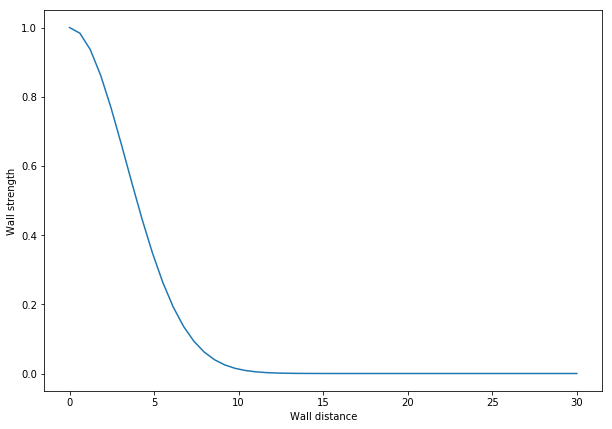

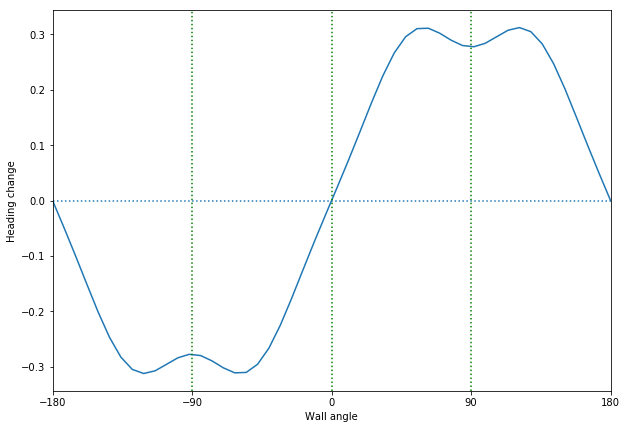

In [121]:
def get_norm_const(OCur, angles):
    return 1/(2*np.pi) * quad(lambda a: OCur(a)**2, -np.pi, np.pi)[0]

def plotFit(model):
    fCur = lambda dist: wall_model.wall_force(dist)
    OCur = lambda angle: wall_model.wall_repulsion(angle)
    norm_const = get_norm_const(OCur, np.linspace(-np.pi, np.pi))
    #norm_const = 1.0/wall_model.scale
    print(wall_model.scale, norm_const)
    print(f"Multiplier is {norm_const * wall_model.scale}")
    
    fig, ax = plt.subplots(figsize=(10,7) )    
    ax.plot(np.linspace(0, 30), fCur(np.linspace(0,30)))
    ax.set_xlabel("Wall distance")
    ax.set_ylabel("Wall strength")
    fig.savefig('../../figures/wall_force.pdf', transparent=True, bbox_inches='tight')    
       
    fig, ax = plt.subplots(figsize=(10,7) )
    ax.plot(np.rad2deg(np.linspace(-np.pi, np.pi)), OCur(np.linspace(-np.pi, np.pi))*wall_model.scale)
    plt.axhline(0, linestyle='dotted')
    ax.axvline(90, linestyle='dotted', c='g')
    ax.axvline(0.0, linestyle='dotted', c='g')
    ax.axvline(-90, linestyle='dotted', c='g')
    ax.set_xticks([-180, -90, 0, 90, 180])
    ax.set_xlim(-180, 180)
    ax.set_xlabel("Wall angle")
    ax.set_ylabel("Heading change")
    fig.savefig('../../figures/wall_odd.pdf', transparent=True, bbox_inches='tight')
    
plotFit(wall_model)

In [104]:
wall_model(np.array([0.0, 10.0]).reshape(-1, 1), np.rad2deg(np.array([-90, -90]).reshape(-1, 1)))

array([-0.05091215])

In [18]:
def toMin(model, xdata_social, ydata):
    yHat = model(xdata_social)
    return np.linalg.norm(yHat - ydata)/len(ydata)
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAnMAAAGtCAYAAAB9bPLMAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz%0AAAALEgAACxIB0t1+/AAAIABJREFUeJzs3Xd4FVXCBvD3pDcSQgIEUkijdwy9C6zAqlgpKiKIgOgq%0Atl3129V1de2wgoUqoqgUXRQRRKlBJEASCJ0UAqRAII0QSE/O90cCGzEhk+TeOXfufX/Pk4dM7s2d%0Ad/d5HQ4zZ84IKSWIiIiIyJjsVAcgIiIioobjYI6IiIjIwDiYIyIiIjIwDuaIiIiIDIyDOSIiIiID%0A42COiIiIyMA4mCMiIiIyMA7miIiIiAyMgzkiIiIiA3NQHcAcfH19ZXBwsOoYRERERHWKjY3NklI2%0Ab+jvW+VgLjg4GDExMapjkIXLuJIBAPDz8FOchIyAfSGt2BWqLyHE2cb8vlUO5oi0mPjtRADAzkd2%0Aqg1ChsC+kFbsCumNgzmyWS8OelF1BDIQ9oW0YldIb0JKqTqDyUVEREheZiUiIiIjEELESikjGvr7%0AvJuVbFZqXipS81JVxyCDYF9IK3aF9KZ0MCeEGC2EiBdCJAkhaj0vLYToLYQoE0Lcp2c+sm6Tv5uM%0Ayd9NVh2DDIJ9Ia3YFdKbsjlzQgh7AB8DGAUgDUC0EOIHKeXxGt73DoBf9E9J1uzvQ/6uOgIZCPtC%0AWrErpDeVN0D0AZAkpUwGACHEagDjABy/4X1/AfBfAL31jUfWbmToSNURyEDYF9KKXSG9qbzM6g+g%0A+qSCtKqfXSeE8AdwN4CFOuYiG5Gcm4zk3GTVMcgg2BfSil0hvVn60iQfAPiblLJCCHHTNwohZgCY%0AAQBBQUE6RCOjm7Z+GgCuBUXasC+kFbtCelM5mEsHEFhtO6DqZ9VFAFhdNZDzBTBWCFEmpfz+xg+T%0AUi4BsASoXJrELInJqrw27DXVEchA2BfSil0hvSlbZ04I4QAgAcAIVA7iogE8IKU8Vsv7VwD4UUr5%0AbV2fzXXmiIiIyCgau86csjNzUsoyIcSTAH4GYA9guZTymBBiVtXri1RlI9sQnxUPAGjv215xEjIC%0A9oW0YldIb3wCBNmsYSuGAeC8FtKGfSGt2BWqL8OemSNS7c0Rb6qOQAbCvpBW7ArpjWfmiIiIrFhF%0AhcSF/CK4OTnAy9VRdRyqAc/METXQ0YtHAQBdWnRRnISMgH0hrfTuipQSmfnFSM0tRFpuAdKq/kzN%0Aqfwz/VIhSsslXBztMG1gCGYODeOgzsrwzBzZLM5rofpgX0grPbqSmlOAdzafxPHzl5GeW4jisorf%0Ave7j7oSAZm4I8Hat+nJDzJkcrI87By9XRzw+LAxT+gfD1cnebBlJu8aemeNgjmxWdHo0AKC3P58U%0AR3VjX0grc3ZFSolvYtPwrw2VT74cFO6LwGaVg7VrfwZ4u8LNqeYLb8fO5eH9n+OxIz4TLZo44+mR%0AbTE+IhCO9iofCEUczNWAgzkiIrI2WVeK8dK6I9hy/AL6hDTD3Pu7I7CZW4M+a//pHLy7+SRizuYi%0A2McNz/6pPW7v2gp2djd/2hKZBwdzNeBgjrSIy4gDAPTw66E4CRkB+0JamaMrW45fwEvrDuNyYRle%0AuK09Hh0U0uiBl5QS209exHs/x+NkRj46tfLEX0e3x9B2zVHXIzTJtDiYqwEHc6QF50BRfbAvpJUp%0Au3KluAz/2nAMa2PS0LGVJ/4zoTs6+Hk2+nOrK6+Q2HDoHOZuiUdqTiH6hjTDX0d3wC1tvE26H6od%0AB3M14GCOtOCZFqoP9oW0MlVXos/k4Nm1cUjPLcTMoWGYM7ItnB3Md8NCSVkFVkenYMG2JGRdKca8%0A8d1xT68As+2P/oeDuRpwMEdEREZVXFaOeVsSsGRXMgK93TBvfHdEBDfTbf8FJWWY/nkMos/k4MtH%0A+6JvqI9u+7ZVjR3M8fYVslnR6dHX7zojqgv7Qlo1pisnMy5j3Ee/YXFkMib2DsSmpwfrOpADADcn%0AByx88BYENXPDzC9jcTrrqq77p/rjmTmyWZwDRfXBvpBWDe3K+rh0vPDNYXi6OuKde7tiRMeWpg9X%0ADynZBbjrk9/g6eKA72YPhLe7k9I81oyXWWvAwRxpwRX9qT7YF9KqIV3ZevwCZn4Zi1vaeGPhg73g%0A4+Fsrnj1Ens2B5OW7kOPgKZYOb2PWefs2TIO5mrAwRwRERlF1KlsTPlsPzr4NcHXj/WDh7NlPWnz%0Ah0Pn8NSqg7i7pz/mje/OZUvMgM9mJWqgPal7AAADAgcoTkJGwL6QVvXpyuG0S5j+eTTaNHPDiql9%0ALG4gBwB3dm+NlOyreP+XBAT7uOPpkW1VR6IbWF5riHTy8raXAXAOFGnDvpBWWruSeCEfU5bvh7e7%0AE1Y+2hfNLHhO2hPDw3E6qwD/2ZqANj5uuKunv+pIVA0Hc2SzFt++WHUEMhD2hbTS0pXUnAJM/nQ/%0AHOzt8NX0vvDzctEhWcMJIfDWPV2RfqkAf/32MFo3dUWfEH3vsqXacc4cERGRji7mF+H+RVG4VFCK%0ANTP7mfyJDuZ0qaAE93yyB7kFJfhu9kAE+7qrjmQVuM4cUQNFnolE5JlI1THIINgX0upmXckrKMXD%0An+5HZn4xPpva21ADOQBo6uaEz6b2BgBMWxGNSwUlihMRwDNzZMO4bhjVB/tCWtXWlYKSMjy0bB+O%0Apl/G8kd6Y1BbX/3DmUj0mRw8uHQfegY1xcpH+8LJgeeGGoNLk9SAgznSIjk3GQAQ6h2qOAkZAftC%0AWtXUleKyckz/PAa/JWXhkwd7YXSXVqrimcz6uHQ8vToO9/Tyx9z7uWRJY3BpEqIG4l/KVB/sC2l1%0AY1fKyiswZ3Ucfk3Mwnv3dbOKgRwAjOvhjzNVd7h29PPEY0P434gqPC9KNmtr8lZsTd6qOgYZBPtC%0AWlXvipQSL393BD8dzcA/bu+E+yMCFaczradGhGNUp5aYuyUe6ZcKVcexWRzMkc16Y9cbeGPXG6pj%0AkEGwL6RV9a68/dNJrI1Jw1Mj2uLRQSGKk5meEAKv3tEJAPDmxhOK09guXmYlm7Xy7pWqI5CBsC+k%0A1bWurIlOweJdyZjcrw2eseKnJgR4u2H2sHDM25KAB5KyMDDcuDd2GBXPzJHNCvQKRKCXdV3yIPNh%0AX0irQK9AZOS64+/fH8Xgtr549Y5OVn9zwIwhoQhq5oZXfziG0vIK1XFsDgdzZLM2J23G5qTNqmOQ%0AQbAvpNXKg99j0heLEOjtho8m9YKDvfX/VeviaI9/3N4JSRev4PM9Z1THsTm8zEo26+3dbwMARoeP%0AVpyEjIB9IS2uFpfh6Y2vobiiHD9PeQpebo6qI+lmZMcWGNa+OT7Ymog7e7RGiyaW/Ygya8LBHNms%0A1fetVh2BDIR9obpUVEg8uzYOHlefw7KJPRDW3EN1JF1V3gzRGbf9Zxfe+Skec8d3Vx3JZlj/uV+i%0AWvh5+MHPw091DDII9oXq8sHWBPx87AJeGTsA93TvojqOEiG+7nh0cAj+eyANsWdzVMexGRzMkc3a%0AEL8BG+I3qI5BBsG+0M38ePgcFmxPwv23BKBF86M23ZUnh4fDz9MFr6w/hvIK63vKlCXiYI5s1tyo%0AuZgbNVd1DDII9oVqczQ9D89/cwi3tPHGG3d3wby982y6K+7ODnj5zx1x7NxlrI5OUR3HJvDZrGSz%0AsgqyAAC+blwTierGvlBNLuYXYdxHv0EAWP/kIDRv4syuoPLJFxOX7EX8hXzseG4YvN2dVEeyaI19%0ANivPzJHN8nXztemDLdUP+0I3Kiotx8yVsbhUUIqlUyLQvIkzAHYFqLwZ4rVxnZFfVIa5W+JVx7F6%0AHMyRzVp3Yh3WnVinOgYZBPtC1V175urBlEuYN747Orf2uv4au1Kpg58nJvdrg6/2peBoep7qOFaN%0AgzmyWQv2LcCCfQtUxyCDYF+ouqW/JmPdgXTMGdkWY7q2+t1r7Mr/PDOqHZq5OeHVH47BGqd1WQql%0Ac+aEEKMBzAdgD2CZlPLtG14fB+B1ABUAygDMkVLurutzOWeOtMgrqvyXopeLVx3vJGJf6H92nLyI%0AaZ9HY0wXP3w0qRfs7H7/qC525ffWxqTir98exrzx3XFPrwDVcSySYefMCSHsAXwMYAyATgAmCSE6%0A3fC2bQC6Syl7AJgGYJm+Kcmaebl48WBLmrEvBADxGfl4atVBdPTzxPv3d//DQA5gV250X68A9Ahs%0Aijc3nUR+UanqOFZJ5WXWPgCSpJTJUsoSAKsBjKv+BinlFfm/U4fuAHiOlkxmzdE1WHN0jeoYZBDs%0AC527VIgpy/fD1ckeS6dEwM2p5ocosSu/Z2cn8NqdnZF9tRgLtiWqjmOVVA7m/AGkVttOq/rZ7wgh%0A7hZCnASwEZVn54hMYmHMQiyMWag6BhkE+2Lb8gpL8chn+3GluAwrpvaBf1PXWt/LrvxR98CmmBAR%0AiM9+O4PEC/mq41gdZXPmhBD3ARgtpZxetT0ZQF8p5ZO1vH8IgFeklCNreX0GgBkAEBQUdMvZs2fN%0AE5ysRkFpAQDAzdFNcRIyAvbFdhWVlmPK8v04kJKLz6f2wYDwmy87wq7ULPtKMYa/vxNdA7zw5aN9%0AIcQfL1HbKsPOmQOQDiCw2nZA1c9qJKXcBSBUCFHjf0VSyiVSyggpZUTz5s1Nm5SskpujGw+2pBn7%0AYpsqKiSeW3sI+07n4P37u9c5kAPYldr4eDhjzsh2+C0pG1GnslXHsSoqB3PRANoKIUKEEE4AJgL4%0AofobhBDhomroLoToBcAZABtAJvHl4S/x5eEvVccgg2BfbI+UEv/68Tg2HjmP/xvbEeN6/GEmUI3Y%0Aldo90DcILT2dMZ9z50xK2WBOSlkG4EkAPwM4AWCtlPKYEGKWEGJW1dvuBXBUCBGHyjtfJ0guVEMm%0AsuzAMiw7wBukSRv2xfYs/TUZK/acwbSBIZg+OETz77ErtXNxtMesoWHYdzoHe5N5bsZU+GxWslml%0A5ZW3yDvaOypOQkbAvtiW9XHpeHp1HP7crRU+nNizxiVIasOu3FxRaTkGv7sDbVt44OvH+qmOYxGM%0APGeOSClHe0cebEkz9sV2/JaUhee/OYR+oc0wb3zNa8ndDLtycy6O9pg5JBR7TmUj+kyO6jhWgYM5%0Aslkr4lZgRdwK1THIINgX23DsXB5mroxFqK8HFk+OgLODfb0/g12p24N928DXw4nrzpkIB3Nks3jA%0ApfpgX6xfak4BHvksGk1cHLBiWm94uTbs7Bq7UjdXJ3vMGBKKXxOzEHs2V3Ucw+OcOSIisnm5V0tw%0A76I9yMovxrePD0C7lk1UR7J6BSVlGPTODnT198Ln0/qojqMU58wRERE1QlFpOaZ/EYO03EIsm9Kb%0AAzmduDk54LHBoYhMyERc6iXVcQyNgzmyWUtjl2Jp7FLVMcgg2BfrlFdYimkronEgJRfzJ/RAn5Bm%0Ajf5MdkW7h/u3gbebI+fONRIHc2Sz1hxbgzXH+DBs0oZ9sT6pOQW4d+EeRJ/Jwdz7u2NM11Ym+Vx2%0ARTt3ZwdMHxyK7Scv4nAaz841FOfMERGRzYk9m4sZX8SgrEJi8eRb0C/UR3Ukm5VfVIpB7+xA72Bv%0ALJvSW3UcJThnjoiIqB42HDqHSUv3oomLA76bPYADOcWauDji0UEh2HriIo6m56mOY0gczJHN+iT6%0AE3wS/YnqGGQQ7IvxSSnx0fZE/GXVQXQP8MK62QMR2tzD5PthV+rvkYHBaOLiwLlzDcTBHNmsDQkb%0AsCFhg+oYZBDsi7GVlFXg+W8O4/1fEnB3T398Ob0vmrk7mWVf7Er9ebo4YtrAEPxy/AKOn7usOo7h%0AcM4cERFZtUsFJZi5Mhb7Tudgzsi2eHpEWwhRv0d0kfnlFZRi0DvbMaitLxY+dIvqOLrinDkiIqJa%0AnMm6ins+2YODKZfwwYQemDOyHQdyFsrLzRGPDAzGT0czEJ+RrzqOoXAwRzZr/t75mL93vuoYZBDs%0Ai/FEn8nB3Z/8htyCEnz1WF/c1dNfl/2yKw336KAQeDg7YMF2zp2rDw7myGZtO70N205vUx2DDIJ9%0AMQ4pJb6NTcODS/fB280J380eiN7BjV8MWCt2peGaujlhyoA22HTkPBIv8OycVpwzR0REVkFKid+S%0AsjF3SzwOplxC35BmWDz5FjR1M8+NDmQeOVdLMOid7RjZsSUWTOqpOo4uOGeOiIhsXvSZHExcshcP%0AfboPGXlFeOuervhyel8O5AyombsTHu4fjA2HzyHp4hXVcQyBgzmyWe/veR/v73lfdQwyCPbFMh1O%0Au4Qpy/fj/kVROJV5Ff+8oxN2PD8Mk/oEwdFezV9x7ErjPTY4BC4O9vh4R5LqKIbgoDoAkSpRaVGq%0AI5CBsC+W5WTGZcz7JQG/HL+Apm6OeGlMBzzcPxiuTvaqo7ErJuDj4YzJ/dtg2a/JeGpEW4T4uquO%0AZNE4Z46IiAzjVOYVfLA1ET8ePgcPJwc8NiQUUwcGo4mLo+poZGKZ+cUY9M523N3TH2/f2011HLNq%0A7Jw5npkjIiKLlldQigOpudh4+DzWHUiDi6M9Zg8Lw2ODQzknzoo1b+KM+yMCsDY6Dc+OaocWni6q%0AI1ksDubIZr29+20AwIuDXlSchIyAfdFHRYVEctYVxJ7NxYGzlxCbknt9EryTgx2mDgzB48PC4Ovh%0ArDhp7dgV05kxOAxf70vBp7+dxktjOqqOY7E4mCObFZcRpzoCGQj7Yh5XissQl3IJB1JyEXs2FwdT%0AcnG5qAwA0NTNEb2CvHFXj9bo1cYb3QOawt3Z8v/aYldMJ8jHDWO7tsLXe1PwxPBwePJyeo04Z46I%0AiEyqokLiUmEpsq8UI/NKMbKvlCD7SjGyrpQg+2oxMvMr/8y6Uoz03EJUSEAIoF2LJujVpil6BXmj%0AVxtvhPq689FbhKPpebj9w914cUwHzBoapjqOWXDOHBERKVFYUo7Ei/k4mZGP+Ix8JFzIR+KFK8i8%0AUozyij+eKLC3E2jm7gQfdyc0b+KMNs3ccE/PANzSxhs9gpryrAvVqIu/FwaF+2L57tOYOjAYzg7q%0A71i2NBzMkc16PfJ1AMA/hv5DcRIyAlvuS1l5Bc5kFyDhwrWB22XEZ+TjbE4Brl3ccXawQ7uWTTAg%0A3AetvFzg6+EMHw9n+Ho4wdfDGb4ezmjq6gg7O+s/02bLXTGXWUPD8NCn+/DdgXRM7BOkOo7F4WCO%0AbFZ8drzqCGQgttiXhAv5+HB7En45loHisgoAgJ0Agn3d0bGVJ+7q6Y8Ofk3QrmUTtPFxh70NDNS0%0AsMWumNvAcB908ffEkl3JGB8RaBP/KKgPzpkjIqLfic/Ix4Ltidh05DzcHO1x7y0B6BbQFB38miC8%0AhQdcHHmZi/S34dA5/GXVQSx66BaM7uKnOo5Jcc4cERGZxMmMy1iwLRGbjmTAw9kBs4eFYfqgUHi7%0Acy03Um9MFz8ENXPDoshTuK1zS94cUw0Hc2SzXtnxCgDgX8P/pTgJGYE19+X4ucpB3OZjlYO4v9wa%0AjkcHhXBB3gay5q6o5GBvh8eGhOIf3x/FvtM56BfqozqSxeBgjmxW6uVU1RHIQKyxL0fT87BgWyJ+%0AOX4BTZwd8NSItnh0YAi83HhXaWNYY1csxf23BOCDLQlYFHmKg7lqOGeOiMjGHD93GfO2JGDriQto%0A4uKAaQNDMI2DODKID7clYu6WBPz09GB0bOWpOo5JNHbOnJ0pwxARkWXbEX8Rd338G/afzsYzI9th%0A999uxTOj2nEgR4YxuX8buDnZY8muZNVRLAYHc2SzXtr6El7a+pLqGGQQ1tCXHfEXMfOLWLRt6YGd%0ALwzH0yPbwsuVgzhTs4auWLKmbk6Y1CcIPxw6h7TcAtVxLAIHc2SzsguzkV2YrToGGYTR+7Iz/iJm%0ArqwcyH01vS+a8Q5VszF6V4zg0UEhEACW/XpadRSLwDlzRERWbmf8RcxYGYu2LSoHcrxLlazBs2vj%0A8NORDOx58VbDL59j6DlzQojRQoh4IUSSEOLFGl5/UAhxWAhxRAixRwjRXUVOIiKjikzIxIyVsQhv%0AzoEcWZdZQ8NQWFqOL6LOqo6inLLBnBDCHsDHAMYA6ARgkhCi0w1vOw1gqJSyK4DXASzRNyVZs+d/%0AeR7P//K86hhkEEbsS2RCJh77IoYDOZ0ZsStG1K5lE4zo0AKfR51BYUm56jhKqTwz1wdAkpQyWUpZ%0AAmA1gHHV3yCl3COlzK3a3AsgQOeMZMUKSwtRWFqoOgYZhNH6sqtqIBdWNZAz+mUoIzFaV4xs1rAw%0A5FwtwdoY217bT9mcOSHEfQBGSymnV21PBtBXSvlkLe9/HkCHa++/Gc6ZIyJbtishE9OrBnJfcyBH%0AVkxKiXsX7sHF/GLsfH4YHOyNeV+noefMaSWEGA7gUQB/u8l7ZgghYoQQMZmZmfqFIyKyIL8m8owc%0A2Q4hBGYNDUNabiE2HjmvOo4yKgdz6QACq20HVP3sd4QQ3QAsAzBOSlnrvd5SyiVSyggpZUTz5s1N%0AHpasz5zNczBn8xzVMcggjNCX3YlZmP55DEJ83bn8iEJG6Io1GdmxJcJbeGBRZDKscYUOLVQO5qIB%0AtBVChAghnABMBPBD9TcIIYIArAMwWUqZoCAjEZEh7E7MwqOfRyPE1x1fP9aPAzmyGXZ2AjOGhOLE%0A+cvYlZilOo4SSteZE0KMBfABAHsAy6WU/xZCzAIAKeUiIcQyAPcCuHbfcZmWa8qcM0dEtuRw2iXc%0AvyiKAzmyWcVl5Rjy7g6E+npg1Yx+quPUW2PnzDmYMkx9SSk3Adh0w88WVft+OoA6b3ggIrJVpeUV%0A+Ou3h+Ht5sRLq2SznB3sMX1QKP696QQOpuSiZ5C36ki6MsQNEETm8MTGJ/DExidUxyCDsNS+LN99%0AGicz8vHPOzvDx8NZdRyC5XbF2k3qGwQvV0d8svOU6ii642CObJaroytcHV1VxyCDsMS+pOYU4D9b%0AEzCqU0uM7uKnOg5VscSu2AIPZwdMGRCMLccvIOFCvuo4uuKzWYmIDEhKiUc+i0bMmRxseXYoWjfl%0A4IEo92oJBry9HWO6+GHehB6q42hmE+vMERHR7/14+DwiEzLx3J/acyBHVMXb3QmT+gRh/aFzSM0p%0AUB1HNxzMkc2asWEGZmyYoToGGYQl9SWvoBSvbTiOrv5emDIgWHUcuoEldcUWPTYkBHYCWPprsuoo%0AuuFgjmyWj6sPfFx9VMcgg7Ckvrzz80nkXC3GW/d0hb2dUB2HbmBJXbFFrbxccXdPf6yJTkVmfrHq%0AOLrgnDkiIgOJOZOD+xZFYfqgEPz99k6q4xBZpFOZVzByXiQeHxqGv47uoDpOnThnjojIRpSUVeDl%0A747Av6krnhnVTnUcIosV1twDY7r4YWXUWVwuKlUdx+w4mCObNXX9VExdP1V1DDIIS+jL0l+TkXDh%0ACv41rjPcnZWu+U43YQldIWD2sHDkF5fhy71n636zwfFoQDYr0DNQdQQyENV9OZN1FfO3JWJsVz+M%0A6NhSaRa6OdVdoUpd/L0wuK0vlu8+jWkDQ+DiaK86ktlwzhwRkYWTUmLyp/txKPUStj43FC09XVRH%0AIjKEqFPZmLR0L14f1xmT+werjlMrzpkjIrJy38elY3dSFv46uj0HckT10C+0GXoGNcXiXckoK69Q%0AHcdsOJgjm/XQuofw0LqHVMcgg1DVl9yrJXj9xxPoEdgUD/Zto/v+qf54bLEcQgjMHhaOtNxCbDh8%0ATnUcs+GcObJZ7X3aq45ABqKqL2/9dAKXC0vx1j1dYcc15QyBxxbLMqJDC7Rr6YGFO09hXHd/q/zv%0AiHPmiIgs1N7kbExcshezhobhxTGWv1YWkaX67mAanllzCEsfjsCoTpZ3AxHnzBERWaHisnK8/N0R%0ABDZzxdMj2qqOQ2Rod3RrjQBvV3yyMwnWeBKLgzmyWRO/nYiJ305UHYMMQu++LI5MRnLmVbxxV1e4%0AOlnvkgrWiMcWy+Ngb4eZQ0JxMOUS9ibnqI5jcpwzRzarh18P1RHIQPTsy+WiUizdlYzbOrfE0HbN%0AddsvmQaPLZbp/ohAzN+WiE92JqF/mHU9O5eDObJZLw56UXUEMhA9+/LV3hTkF5fhyeG8vGpEPLZY%0AJhdHe0wbFIJ3N8fjSFoeugZ4qY5kMrzMSkRkQYpKy7H8t9MYFO5rVX/ZEFmCh/q1QRNnByyMTFId%0AxaQ4mCObde/ae3Hv2ntVxyCD0Ksv3x1MR2Z+MR4fFmb2fZF58NhiuTxdHDG5fxv8dDQDpzKvqI5j%0AMhzMkc3qH9Af/QP6q45BBqFHX8orJBZHnkJXfy8MsLI5PbaExxbLNm1QCJzs7bA48pTqKCbDdeaI%0AiCzEpiPnMfurA/j4gV74c7dWquMQWa1X1h/Fqv0piHxhOFo3dVUdh+vMERFZAyklFkWeQrCPG0Z3%0A8VMdh8iqzRxaOY3h4x3WMXeOgzmyWXeuuhN3rrpTdQwyCHP3Zc+pbBxOy8OMIWGwt8LHDdkSHlss%0An39TV4yPCMTamFSk5RaojtNoXJqEbNaIkBGqI5CBmLsviyJPwdfDGff08jfrfsj8eGwxhieGh+Ob%0AmDR8vCMJb93TTXWcRuGcOSIixY6m5+H2D3fjb6M78C5WIh29uv4ovtqXgh3PD0NgMzdlOThnjojI%0A4BZGnkITZwc82C9IdRQimzJ7eDjs7AQ+3J6oOkqjcDBHNmvMV2Mw5qsxqmOQQZirL2ezr+KnI+fx%0AQL8geLo4mvzzSX88thhHS08XPNg3CP89kI4zWVdVx2kwzpkjm3VHuztURyADMVdfluxKhoOdHR4d%0AGGKWzyf98dhiLI8PC8Oq/Sn4cHsS5o7vrjpOg3DOHBGRIhfzizDonR24t5e/4SdgExnZGz8ex/Lf%0ATmPrs0MR2txD9/1zzhwRkUGt+O0MSssr8NjgUNVRiGzazKFhcHawx4fbjbnuHAdzZLNGfjESI78Y%0AqToGGYSp+5JfVIqVe89iTBc/JWcCyHx4bDGe5k2c8XD/Nlgfl46ki/mq49Qb58yRzZrQeYLqCGQg%0Apu7L1/tSkF9UhllDuRSJteGxxZhmDAnFyr1nMX9bEj6c1FN1nHrhnDkiIp0Vl5Vj8Ds70LalB76a%0A3k91HCKxPR96AAAgAElEQVSq8u7mk1gYeQo/zxmCdi2b6LZfzpkjIjKY7w+m42J+Mc/KEVmYxwaH%0Awt3JAfO3GmvdOQ7myGYNWzEMw1YMUx2DDMJUfSmvkFgcmYzOrT0xKNy38cHI4vDYYlze7k6YOjAY%0AG4+cx8mMy6rjaKZ0MCeEGC2EiBdCJAkhXqzh9Q5CiCghRLEQ4nkVGcl6PdLjETzS4xHVMcggTNWX%0ALcczkJx1FY8PC4MQovHByOLw2GJs0weFoomzAz7YYpyzc8rmzAkh7AEkABgFIA1ANIBJUsrj1d7T%0AAkAbAHcByJVSvq/lszlnjogskZQSd32yB5cKSrD9uWGwt+NgjsgS/WdLAuZvS8TGpwahc2svs+/P%0AyHPm+gBIklImSylLAKwGMK76G6SUF6WU0QBKVQQk61ZaXorSclaLtDFFX6KSs3Eo9RIeGxzKgZwV%0A47HF+KYNCoGniwM+MMjcOZWDOX8AqdW206p+1iBCiBlCiBghRExmZmajw5H1G7VyFEatHKU6BhmE%0AKfqyKDIZvh7OuO+WABOlIkvEY4vxebk6YvrgUGw5fgFH0vJUx6mT1awzJ6VcAmAJUHmZVXEcMoDp%0AvaarjkAG0ti+JF7Ix66ETLxwW3u4ONqbKBVZIh5brMPUgcH4dPdpfLA1AZ8+0lt1nJtSOZhLBxBY%0AbTug6mdEunio20OqI5CBNLYvq/anwtFeYGLvwLrfTIbGY4t1aOLiiBlDQvHez/GIS72EHoFNVUeq%0AlcrLrNEA2gohQoQQTgAmAvhBYR6yMQWlBSgoLVAdgwyiMX0pKi3HuoNp+FMnP/h4OJs4GVkaHlus%0Ax5QBwfB2c8QHWxNUR7kpZYM5KWUZgCcB/AzgBIC1UspjQohZQohZACCE8BNCpAF4FsDfhRBpQghP%0AVZnJuoz9aizGfjVWdQwyiMb05edjGbhUUIqJfXhWzhbw2GI9PJwdMHNoGHbGZyL2bK7qOLVSOmdO%0ASrkJwKYbfrao2vcZqLz8SmRyj0c8rjoCGUhj+rJ6fyoCm7liYBgXCbYFPLZYl4f7t8GyX5Px7uaT%0AWD2jn0WuD6lpMCeEcAUQJKWMN3MeIt1M6MKHYZN2De3LmayriErOxvN/agc7LkdiE3hssS5uTg54%0AekRb/GP9MWw7cREjO7VUHekP6rzMKoS4A0AcgM1V2z2EEJzbRoaXV5SHvCLLv+WcLEND+7I6OhX2%0AdgL3R/ASq63gscX6TOwThFBfd7z10wmUlVeojvMHWubM/ROVC/xeAgApZRyAEDNmItLFuNXjMG71%0AuLrfSISG9aW0vALfxqZhePsWaOnpYqZkZGl4bLE+jvZ2+NuYDjiVeRVrYlLr/gWdabnMWiqlzLvh%0AGjHXcSPDe6rvU6ojkIE0pC/bTlxA1pViPNCXZ+VsCY8t1ulPnVqid7A3/rMlEeN6+MPD2XKW6tWS%0A5JgQ4gEA9kKItgCeArDHvLGIzO+ejveojkAG0pC+rNqfilZeLhjaroUZEpGl4rHFOgkh8PLYjrj7%0Akz1YsisZz45qpzrSdVous/4FQGcAxQBWAbgMYI45QxHpIasgC1kFWapjkEHUty9puQXYlZiJ+yMC%0A+RxWG8Nji/XqGeSNP3drhaW7knHhcpHqONfVOZiTUhZIKf9PStlbShlR9b3l/C8gaqD71t6H+9be%0ApzoGGUR9+7I2Jg0AMD6CqyvZGh5brNvfbuuAsooK/GeL5SwkXOdlViHEBvxxjlwegBgAizmwI6N6%0Arv9zqiOQgdSnL+UVEt/EpGJI2+YI8HYzYyqyRDy2WLcgHzdM7heMFXtOY9qgELRr2UR1JAgpb34v%0AgxBiPoDmqLzECgATUHmpVQLwlFJONmvCBoiIiJAxMTGqYxCRjdp+8gKmrYjBood6YXSXVqrjEJGJ%0A5V4twZD3dqB3cDMsf6R3oz9PCBErpYxo6O9ruQFigJSyetINQohoKWVvIcSxhu6YSLWMKxkAAD8P%0AP8VJyAjq05ev96XC18MZIzpa3uKiZH48tlg/b3cnPDk8HG/9dBJ7TmVhgOKnu2i5AcJDCBF0baPq%0Ae4+qzRKzpCLSwcRvJ2LitxNVxyCD0NqXC5eLsCP+Iu67JQCO9soef00K8dhiG6YMCIZ/U1e8uekE%0AKirUrtim5czccwB2CyFOARCoXDB4thDCHcDn5gxHZE4vDnpRdQQyEK19+SYmFeUVEhN7c205W8Vj%0Ai21wcbTHC7e1x5w1cfjh0Dnc1dNfWZY658wBgBDCGUCHqs14S7/pgXPmiEiFigqJoe/vQEBTN6ya%0A0U91HCIys4oKiTs/3o3cq6XY9txQuDjaN+hzGjtnTus1gFtQudZcdwDjhRAPN3SHRJYiNS8VqXmW%0A91gWskxa+vLbqSyk5hRiYh+elbNlPLbYDjs7gZfHdET6pUJ8vueMshxaliZZCSAMQByA8qofSwBf%0AmDEXkdlN/q7yRuydj+xUG4QMQUtfVu9PRVM3R9zWmRPfbRmPLbZlQLgvhrdvjo92JGF8RCC83Z10%0Az6BlzlwEgE5Sy/VYIgP5+5C/q45ABlJXX7KvFOOX4xl4uH9wgy+1kHXgscX2vDS2I0Z/sAsfbk/C%0AK3d00n3/WgZzRwH4AThv5ixEuhoZOlJ1BDKQuvry3wNpKC2XmMRLrDaPxxbb065lE4yPCMTKvWcw%0AZUAbtPFx13X/WubM+QI4LoT4WQjxw7UvcwcjMrfk3GQk5yarjkEGcbO+SCmxOjoVEW28Ed5C/Wrw%0ApBaPLbbp2VHt4GBnh3d/jtd931rOzP3T3CGIVJi2fhoAzmshbW7Wl/2nc5CceRWz7w/XORVZIh5b%0AbFMLTxc8NiQUC7YlYvqgXPQM8tZt33UO5qSUkXoEIdLba8NeUx2BDORmfVkdnYomLg74c1c+uot4%0AbLFlM4eE4ut9KXhz0wmsndkfQghd9qvlbtZ+AD4E0BGAEwB7AFellJ5mzkZkVkODh6qOQAZSW1/y%0ACkqx6ch5jI8IhKsTb3wgHltsmbuzA577Uzu8tO4Ifjx8Hnd0b63LfrXMmfsIwCQAiQBcAUwH8LE5%0AQxHpIT4rHvFZ+s9tIGOqrS/fHUxDcVkF15aj63hssW3jIwLRubUn3tp0AgUlZbrsU9OiwVLKJAD2%0AUspyKeVnAEabNxaR+c38cSZm/jhTdQwyiJr6cu3Gh24BXujc2ktRMrI0PLbYNns7gX/e2Rnn8oqw%0AaOcpXfap5QaIAiGEE4A4IcS7qFyihE+PJsN7c8SbqiOQgdTUl7jUSziZkY837+6qIBFZKh5bqHdw%0AM9zZvTUW70rG/RGBCGzmZtb9aRmUTa5635MArgIIBHCvOUMR6WFA4AAMCBygOgYZRE19WRuTCldH%0Ae9zZQ595MWQMPLYQALw0tgPshMCbm06YfV91DuaklGellEVSystSyteklM9WXXYlMrSjF4/i6MWj%0AqmOQQdzYl6LScvx46DzGdm0FD2ctFznIVvDYQgDQyssVs4eF4aejGdiTlGXWfdU5mBNCDBRCbBFC%0AJAghkq99mTUVkQ6e3PQkntz0pOoYZBA39uXnYxnILy7DfbcEKExFlojHFrrmsSGhCGzmitc2HEdZ%0AeYXZ9qPln5OfAngGQCyAcrMlIdLZe6PeUx2BDOTGvnwbmwb/pq7oG9JMUSKyVDy20DUujvb4v7Gd%0AMOvLWHy1LwVTBgSbZT9aBnN5UsqfzLJ3IoV6+/dWHYEMpHpfzucVYndSFv5ya1vY2emzKCgZB48t%0AVN1tnVtiYLgP5m1JwB3dW6OZu5PJ91HrZVYhRC8hRC8AO4QQ7wkh+l/7WdXPiQwtLiMOcRlxqmOQ%0AQVTvy7oD6ZASuLeXv+JUZIl4bKHqhBB49Y7OuFJchrm/mGf9wZudmZt7w3ZEte8lgFtNH4dIP3M2%0AzwHA5yeSNtf6smPKDvz3QBr6hDRDGx93xanIEvHYQjdq17IJJvdrgy+izuDBvm3QqbVpH6JV62BO%0ASjncpHsisjAfjP5AdQQykGt9OZh6CcmZVzFrSJjiRGSpeGyhmjwzsh3Wx6XjnxuOYc2MfiZ9bquW%0Au1nfFEI0rbbtLYR4w2QJiBTp4dcDPfx6qI5BBnGtL9/GpsHV0R5ju7VSHYksFI8tVBMvN0c8f1t7%0A7D+dg41Hzpv0s7UsGjxGSnnp2oaUMhfAWJOmIFIgOj0a0enRqmOQQUSnR2P32b3YcOgcxnTx49py%0AVCseW6g2E3sHoVMrT7y58QQKS0y3QIiWwZy9EML52oYQwhWA803eT2QIL2x5AS9seUF1DDKIF7a8%0AgMc3PIv8Iq4tRzfHYwvVpvpzWxdGmu65rVr+afkVgG1CiM+qtqcC+NxkCYgU+WjsR6ojkIF8NPYj%0AvLzuCLKbuqJfqI/qOGTBeGyhm+kT0gx3dG+NxZGnMD4iAAHejX9uq5bHeb0D4A0AHau+XpdSvtvo%0APQMQQowWQsQLIZKEEC/W8LoQQiyoev0wl0QhU+rSogu6tOiiOgYZhK9zOI6e9cQ9vfy5thzdFI8t%0AVJeXxnSAEDDZc1s1TfqQUm4GsNkke6wihLAH8DGAUQDSAEQLIX6QUh6v9rYxANpWffUFsLDqT6JG%0A25O6BwD4QGzS5P2dG1AgzuLeXsNURyELx2ML1aV1U1fMHhaOeVsSsOdU45/bqmXOnLn0AZAkpUyW%0AUpYAWA1g3A3vGQfgC1lpL4CmQog6byGTps9KVujlbS/j5W0vq45BBiClxKeH/41yj68R7Mu15ejm%0AeGwhLWYMCUWAtyte++F43W+ug8rBnD+A1GrbaVU/q+97/iAhIx/fxFT+Wml5BSYsjsJ3B9MAAIUl%0A5ZiwOAobDp0DAFwuKsWExVHYfLTyNuGcqyWYsDgKW49fAABczC/ChMVR2Bl/EQBw7lIhJiyOwu7E%0AypF0SnYBJiyOwt7kbADAqcwrmLA4CrFncwAA8Rn5mLA4CodSK28IPnYuDxMWR+HYuTwAwKHUS5iw%0AOArxGfkAgNizOZiwOAqnMq8AAPYmZ2PC4iikZBcAAHYnZmHC4iicu1QIANgZfxETFkfhYn4RAGDr%0A8QuYsDgKOVdLAACbj57HhMVRuFxUCgDYcOgcJiyOun4XzXcH0zBhcRRKqx4A/E1MKiYsjrr+/+Wq%0A/Sl4cNne69sro85gyvL917eX7z6N6Z//766tJbtOYdbK2Ovbn+xMwpNfH7i+vWBbIuasPnh9e94v%0A8Xj+m0PXt9/ZfBIvrTt8ffvfG4/jH98fvb792oZjeG3Dsevb//j+KP698X//Iby07jDe2Xzy+vbz%0A3xzCvGorbs9ZfRALtiUCABbfvhj+eAqf7Ey6/vqslbFYsut/k1Knfx6N5btPX9+esnw/Vkadub79%0A4LK9WLU/5fr2hMVR7J4Vdu9QWh7cCh5HP++/XX+9Md0DgCe/PsDuWWn3hrZ4Gf546vq2JR33AHbP%0AUrrn4miPWzu0QPyFfDSWysGcSQkhZgghYoQQMSXlFSgw4S2/ZJ3a+7aHt1Ow6hhkAN/GpsJFBKCb%0AXyfVUcgAWrqF8thCmnT190J488af7RdS3vyipBDiCP545TIPQAyAN6SU2Q3asRD9AfxTSnlb1fZL%0AACClfKvaexYD2CmlXFW1HQ9gmJTypqvtObdqK19YuA5v3NW1IdHIRkSeiQQADA0eqjgJWbKi0nL0%0A+fdWtAtKxV9ubcu+UJ14bKH6EkLESikj6n5nzbScmfsJwEYAD1Z9bUDlQC4DwIqG7hhANIC2QogQ%0AIYQTgIkAfrjhPT8AeLjqrtZ+APLqGsgBgI+7E77el4Lj5y43Ih5Zu1d3vopXd76qOgZZuK0nLuBy%0AURlOFX/GvpAmPLaQ3rTczTpSSll9SZAjQogDUspeQoiHGrpjKWWZEOJJAD8DsAewXEp5TAgxq+r1%0ARQA2ofJpE0kAClC5xl2dWnq6AK6OeG3DMaw28fPPyHosH7dcdQQygG9j09DKywVfjP8C9lyShDTg%0AsYX0pmUwZy+E6COl3A8AQojeqBx8AUBZY3YupdyEygFb9Z8tqva9BPBEfT/X3k5gzp/a4+/fH8XG%0AI+dxe7fWjYlJVirUO1R1BLJwFy8XYVdCJh4fFoa2PmGq45BB8NhCetNymXU6gE+FEKeFEGcAfArg%0AMSGEO4C3bvqbCk3qE4SOZnj+GVmPrclbsTV5q+oYZMG+O5iOCgnc2yuAfSHN2BXSW51n5qSU0QC6%0ACiG8qrbzqr281lzBGsveTuC1Oztj/OIoLIo8hWdGtVMdiSzMG7veAACMDB2pOAlZIiklvo1Nwy1t%0AvBHa3APTNrIvpA2PLaS3OgdzQghnAPcCCAbgcG3+mZTyX2ZNZgJ9Qprh9m6tsCjyFO430fPPyHqs%0AvHul6ghkwQ6n5SHx4hW8eXflXfHsC2nFrpDetFxmXY/KJzGUAbha7csQXh7b0aTPPyPrEegViECv%0AQNUxyEJ9G5sGZwc7/Llb5UNn2BfSil0hvWm5ASJASjna7EnM5Mbnnw0I81UdiSzE5qTKxw2PDjds%0AvclMisvK8cOhc7itsx+8XB0BsC+kHbtCetNyZm6PEMLQq+9Wf/5ZWdXjW4je3v023t79tuoYZIG2%0AnbiIvMJS3HdLwPWfsS+kFbtCetNyZm4QgEeEEKcBFAMQqFw1pJtZk5mQi6M9/m9sRzz+1QF8vT8F%0AD/cPVh2JLMDq+1arjkAW6tvYNPh5umBg+P/O5LMvpBW7QnrTMpgbY/YUOhjdxQ/9Q30w95cE3NGt%0ANbzdnVRHIsX8PPxURyALdPFyESITMjFjSOjvFglmX0grdoX0VutlViGEZ9W3+bV8GYoQAq/e2Qn5%0ARaWYuyVedRyyABviN2BD/AbVMcjCfB+XjvIKiXt7Bfzu5+wLacWukN5udmbuawC3A4gFIFF5efUa%0ACcBwS1x38PPE5H5tsHLvWTzQpw06tfas+5fIas2NmgsAuKP9HYqTkKW4trZcz6CmCG/h8bvX2BfS%0Ail0hvYnKJ2ZZl4iICBkTE1Pja5cKSjD8/Z1o17IJn9tq47IKsgAAvm68w5kqxZ7Nxb0L9+DNu7vi%0Agb5Bv3uNfSGt2BWqLyFErJQyoqG/X+uZOSFEr5v9opTyQEN3qlJTNyc8+6f2+Mf3R7HpSMb1NaTI%0A9vBASzdavT8Fbk72uLPHH5/nzL6QVuwK6e1ml1nnVv3pAiACwCFUXmrtBiAGQH/zRjOfB/oE4au9%0AZ/Hvjcdxa4cWcHWyVx2JFFh3Yh0A4J6O9yhOQpYgv6gUPx4+j3E9WsPD+Y+HRvaFtGJXSG+13gAh%0ApRwupRwO4DyAXlLKCCnlLQB6AkjXK6A52NsJ/PPOzjiXV4RFkadUxyFFFuxbgAX7FqiOQRZifdw5%0AFJaWY2KfoBpfZ19IK3aF9KZlaZL2Usoj1zaklEeFEB3NmEkX/UJ98OeurbBkVzIe6BuElp4uqiOR%0AztZPXK86AlmQ1dEp6ODXBN0DvGp8nX0hrdgV0puWJ0AcFkIsE0IMq/paCuCwuYPp4a+j26OsogLz%0AfklQHYUU8HLxgpdLzX9xk205mp6Ho+mXMalPUK03RbEvpBW7QnrTMpibCuAYgKervo5X/czw2vi4%0A46F+bfBNbCriMwy3dB410pqja7Dm6BrVMcgCrNqfAmcHO9zVw7/W97AvpBW7QnqrczAnpSySUv5H%0ASnl31dd/pJRFeoTTw1O3toW7swPe+umE6iiks4UxC7EwZqHqGKRYQUkZ1sedw5+7toKXm2Ot72Nf%0ASCt2hfRW55w5IURbAG8B6ITKO1sBAFJKwy0aXBNvdyc8MTwcb/90Er8lZf3uWYxk3TY9uEl1BLIA%0APx4+jyvFZbXe+HAN+0JasSukNy2XWT8DsBBAGYDhAL4A8KU5Q+ntkQHB8G/qijc3nUBFhfUtokw1%0Ac3N0g5ujm+oYpNjq/SkIa+6O3sHeN30f+0JasSukNy2DOVcp5TZUPi3irJTynwD+bN5Y+nJxtMfz%0At7XDsXOX8X2coVddoXr48vCX+PKwVf27hOop4UI+DqRcwsTetd/4cA37QlqxK6Q3LYO5YiGEHYBE%0AIcSTQoi7AXjU9UtGM667P7r4e+L9n+NRVFquOg7pYNmBZVh2YJnqGKTQqv0pcLQXuKdX7Tc+XMO+%0AkFbsCumtzmezCiF6AzgBoCmA1wF4AnhPSrnX/PEa5mbPZr2ZPUlZeGDZPrw4pgNmDQ0zQzKyJKXl%0ApQAAR/vaJ72T9SoqLUe/t7ZhYLgvPn7gpk8vBMC+kHbsCtWX2Z7Neo2UMrpqRxVSSqtYkqQ2A8J9%0AMbx9c3y8IwkTIgLh7e6kOhKZEQ+0tu3nYxm4VFCKSb1vfuPDNewLacWukN7qvMwqhOgvhDgO4GTV%0AdnchxCdmT6bIS2M74mpxGRZsT1QdhcxsRdwKrIhboToGKbJqfwoCm7liQJiPpvezL6QVu0J60zJn%0A7gMAtwHIBgAp5SEAQ8wZSqV2LZtgfEQgvtx7Fmezr6qOQ2bEA67tOp11FXuTczCxdxDs7G5+48M1%0A7Atpxa6Q3rQ8mxVSytQb7vSy6jsEnh3VDuvjzuHdzfH4+MG659KQMe18ZKfqCKTI6ugU2NsJ3H9L%0AgObfYV9IK3aF9KblzFyqEGIAACmEcBRCPI/KGyKsVgtPFzw2JBQbj5zHgZRc1XGIyIRKyirw39g0%0A3NqhBVp4utT9C0REFk7LYG4WgCcA+ANIB9CjatuqzRwSCl8PZ7y58QTquuOXjGlp7FIsjV2qOgbp%0AbOuJC8i6UoJJfQLr9XvsC2nFrpDetDybNUtK+aCUsqWUsoWU8iEpZbYe4VRyd3bAM6PaIuZsLn4+%0AdkF1HDKDNcfWYM0xPgzb1qzan4JWXi4Y2q5FvX6PfSGt2BXSW63rzAkhPgRQ6ykpKeVT5grVWA1d%0AZ+5GZeUVGD3/V5RXSPzyzBA42ms5kUlElio1pwBD3tuBp25ti2dGtVMdh4gIQOPXmbvZ6CQGQGzV%0A153Vvr/2ZfUc7O3w4ugOOJ11Fav2p6iOQ0SNtDYmFQAwvnf9LrESEVmyWu9mlVJ+fu17IcSc6tu2%0AZETHFugb0gzztybi7p7+aOLCxSCtxSfRlcslzu49W3ES0kNZeQXWxqRiaLvm8G/qWu/fZ19IK3aF%0A9Kb1uqHN3gEghMD//bkjsq+WYFHkKdVxyIQ2JGzAhoQNqmOQTnbGZ+LC5WJM1PjEhxuxL6QVu0J6%0A07TOnK3rFtAUd3ZvjWW/nsbD/YPRkssZWIWfHvxJdQTS0eroFPh6OGNEx/rd+HAN+0JasSukt1rP%0AzAkh8oUQl4UQlwF0u/b9tZ/rmNEiPPendiirkFi4k2fniIwmI68I209exP0RAbyRiYisTq1HNSll%0AEymlZ9WXQ7Xvm0gpPRuzUyFEMyHEFiFEYtWf3rW8b7kQ4qIQ4mhj9mcKbXzccV+vAHy9PwXn8wpV%0AxyETmL93Pubvna86Bungm5hUVEhgYiNufGBfSCt2hfSm6p+oLwLYJqVsC2Bb1XZNVgAYrVeoujx5%0AazgqKiQ+2cGzc9Zg2+lt2HZ6m+oYZGYVFRJrYlIxIMwHbXzcG/w57Atpxa6Q3lTNmRsHYFjV958D%0A2Angbze+SUq5SwgRrFeougQ2c8P9EYFYHZ2CWcPCGnRHHFmOHyb9oDoC6SAyIRNpuYX46+gOjfoc%0A9oW0YldIb6rOzLWUUp6v+j4DQEtFOertyVvDAQAf70hSnISItFgYeQqtvFwwurOf6ihERGZhtsGc%0AEGKrEOJoDV/jqr9PVj6CotFLnwghZgghYoQQMZmZmY39uFr5N3XFxN5BWBuditScArPth8zv/T3v%0A4/0976uOQWZ0ICUX+0/nYPrgUDg5NO5wx76QVuwK6c1sl1mllCNre00IcUEI0UpKeV4I0QrARRPs%0AbwmAJUDl47wa+3k3M3t4GNZEp+LjHUl4+95u5twVmVFUWpTqCGRmi3aegperY6NufLiGfSGt2BXS%0Am6o5cz8AmALg7ao/1yvK0SCtvFzxQN8grNx7FrOHhSPIx011JGqA/47/r+oIZEZJF/Pxy/ELeOrW%0AcLg7N/5Qx76QVuwK6U3VnLm3AYwSQiQCGFm1DSFEayHEpmtvEkKsAhAFoL0QIk0I8aiStDV4fFgY%0AHOwEPtyeqDoKEdVgcWQyXBztMGVAsOooRERmpeTMnJQyG8CIGn5+DsDYatuT9MxVHy09XfBg3zb4%0APOoMnhgejmDfhi95QGq8vfttAMCLg2pbGYeM6nxeIb6PS8cDfYLg4+Fsks9kX0grdoX0xqXQG2HW%0AsFA42gss4Nk5Q4rLiENcRpzqGGQGn/56GhUSmD441GSfyb6QVuwK6U1U3kxqXSIiImRMTIwu+3pz%0A0wks+zUZW54dirDmHrrsk4hqd6mgBAPf3o5RnVrig4k9VcchIqqTECJWShnR0N/nmblGmjEkFM4O%0A9liwjWfniCzByqizuFpSjplDw1RHISLSBQdzjeTr4YwpA4Lxw6FzSLqYrzoO1cPrka/j9cjXVccg%0AEyosKceKPWcwvH1zdGzVqEdI/wH7QlqxK6Q3DuZMYMaQULg52uODrTw7ZyTx2fGIz45XHYNM6JvY%0AVGRfLcEsM5yVY19IK3aF9MY5cyby3s8n8cnOU9j89BC092ui676JCCgrr8Cw93eiRRNn/PfxARBC%0AqI5ERKQJ58xZiMcGh8LdyQHztyWojkJkkzYeOY+03ELMGhrGgRwR2RQO5kykqZsTpg0MxqYjGThx%0A/rLqOKTBKztewSs7XlEdg0xASolFkckIb+GBkR1bmmUf7Atpxa6Q3jiYM6FHB4WiiYsDPtjKs3NG%0AkHo5FamXU1XHIBOITMjEifOXMXNIKOzszHNWjn0hrdgV0hvnzJnY/K2J+M/WBPz4l0Ho4u+lJAOR%0ArZmwOAopOQWIfGE4nBz4b1QiMhbOmbMwUwcFw9PFgXe2EunkYEou9p3OwaODQjiQIyKbxCOfiXm6%0AOGLGkFBsPXEBh9MuqY5DN/HS1pfw0taXVMegRloUeQpero6Y1CfIrPthX0grdoX0xsGcGTwyMARN%0A3UmdaZ8AACAASURBVBzx0fYk1VHoJrILs5FdmK06BjVC0sUr+OX4BTzcvw3cnR3Mui/2hbRiV0hv%0A5j362SgPZwdM6R+M+dsSkXghH21bct05S7TkjiWqI1AjLdl1Cs4OdnhkQLD598W+kEbsCumNZ+bM%0A5JEBwXBzssfCyFOqoxBZpfN5hfjuYDrGRwTCx8NZdRwiImU4mDMTb3cnTOoThB/iziEtt0B1HKrB%0A8788j+d/eV51DGqg5btPo0JWLtitB/aFtGJXSG8czJnR9MEhEAJYuitZdRSqQWFpIQpLC1XHoAbI%0AKyjF1/tScHu3Vghs5qbLPtkX0opdIb1xnTkz+9u3h/F9XDp+e/FW+PJSEJFJLNiWiHlbErDpqcHo%0A1NpTdRwiokbhOnMWbubQUJSUV+Cz306rjkJkFVJzCrBw5yn8qVNLDuSIiMDBnNmFNvfA2C6t8EXU%0AWeQXlaqOQ9XM2TwHczbPUR2D6kFKiVfWH4UQwKt3dtZ13+wLacWukN44mNPB48PCkF9Uhi/3pqiO%0AQmRoG4+cx474TDw7qh38m7qqjkNEZBE4Z04nkz/dhxPn87H7b8Ph4mivOg6R4eQVlmLkvEi09HTG%0A97MHwsGe/xYlIuvAOXMGMXtYOLKuFOOb2DTVUYgM6d3NJ5F9pRhv3d2NAzkiomp4RNRJv9Bm6BnU%0AFEt2nUJZeYXqOATgiY1P4ImNT6iOQRrEns3FV/tS8MiAEHQN8FKSgX0hrdgV0hsHczoRQmD2sHCk%0A5hTix8PnVcchAK6OrnB15LwrS1daXoGX1x1Bay8XPPendspysC+kFbtCeuOcOR1VVEiMnr8LAgI/%0APT0YdnZCdSQii/fxjiS893M8lj0cgZGdWqqOQ0RkcpwzZyB2dgKPDwtD/IV8bD95UXUcIot3Nvsq%0AFmxLxOjOfhzIERHVgoM5nd3RrTUCvF3xyc4kWONZUSOZsWEGZmyYoToG1UJKib9/fxSO9nb4p85r%0AytWEfSGt2BXSGwdzOnOwt8PMIaE4kHIJ+07nqI5j03xcfeDj6qM6BtXih0Pn8GtiFv46uj38vFxU%0Ax2FfSDN2hfTGOXMKFJWWY9A729GptRe+mNZHdRwii3OpoAQj5kYisJkb/vv4ANhzfikRWTHOmTMg%0AF0d7TBsUgl0JmTianqc6DpHFeWvTSVwqLMVb93TlQI6IqA4czCnyUL82aOLsgIU7T6mOYrOmrp+K%0Aqeunqo5BN9iXnI01MamYPjgEHVt5qo5zHftCWrErpDcH1QFslaeLIyb3b4OFkaeQnHkFoc09VEey%0AOYGegaoj0A2Ky8rx8ndHEODtijkj1K0pVxP2hbRiV0hvnDOnUGZ+MQa9sx139fDHO/d1Ux2HSLkF%0A2xIxb0sCVkztjWHtW6iOQ0SkC86ZM7DmTZwxPiIQ6w6m4Xxeoeo4REolZ17BRzuScEf31hzIERHV%0AAwdzis0YEooKCSz79bTqKDbnoXUP4aF1D6mOQQDKyivw8ndH4OJgh3/c3lF1nBqxL6QVu0J6UzKY%0AE0I0E0JsEUIkVv3pXcN7AoUQO4QQx4UQx4QQT6vIam6BzdxwZ/fW+HpfCi4VlKiOY1Pa+7RHe5/2%0AqmPYvLLyCjyz9hD2Jufg77d3Qosm6teUqwn7QlqxK6Q3JXPmhBDvAvj/9u48Oqr6/v/48w0EAiGs%0AAYJACMgqqICAglsAqYgLWhShKlAXcGnVat1+tbX92sVqtS6VKkUEl6q4glurqOACIotB2SKLQFgC%0ABkIIhCXL5/fHDDZgwElI7p0783qckzN3Zu698+b4OjNv7/3c+9nunLvPzO4EGjvn7jhknZZAS+fc%0AIjNLBhYCFzrnlv3Y/oMyZu6AFTk7GfLwJ9wyuBM3DurodzkinjnQyL25eBN3ntOFa8881u+SREQ8%0AF9Qxc8OAqeHlqcCFh67gnNvsnFsUXi4AlgOtPKvQQ11SGzCgczOmzFnLnv0lfpcj4oniklJuUSMn%0AInLU/GrmWjjnNoeXc4AjzqBtZulAT2Be9Zbln2vPPJbtu/fzysJsv0uJGyNfGcnIV0b6XUZcKi4p%0A5daXFzNj8SbuGBKMRk55kUgpK+K1arvPnJnNBFLLees3ZZ8455yZHfZcr5nVB14FbnbO7TzCeuOA%0AcQBpaWmVqtlPfds1oWdaIyZ+soZRfdOoVVPXplS3Hqk9/C4hLh1o5KZnhhq56zKiv5ED5UUip6yI%0A1/waM5cFZDjnNofHxs1yzv1gtKiZJQBvAf91zj0U6f6DNmbugP8uzWH8swt5dFRPLjjxGL/LEaly%0AJaWOW6ZlMj1zE7cP6cz1GR38LklExHdBHTM3AxgTXh4DTD90BTMz4ClgeUUauSAb3LUF7Zsl8cSs%0A1cTizZwlvqmRExGpHn41c/cBg81sJXBW+DlmdoyZvRNe51TgCmCgmWWG/4b6U643atQwxp/RnmWb%0Ad/LJyly/y4l5w6cNZ/i04X6XERdKSh23hhu5284OZiOnvEiklBXxmi9zszrntgGDynl9EzA0vPwp%0AYB6X5rsLe7biofe/4YnZqzmjUzO/y4lp/Vr387uEuFBS6vj1y4t5I9zI3TAgeI0cKC8SOWVFvKa5%0AWaPQk7NX85d3VzDjF6dyQutGfpcjUmkHGrnXv9wY6EZORKQ6BXXMnBzBz05OI7lOLZ6cvcbvUkQq%0AraTUcZsaORGRaufLaVY5suTEBC47pS0TP17N2tzdpKck+V1STLrghQsAmDFqhs+VxJaSUsc7X2/m%0AsQ9X8s2WXfz6J51iopFTXiRSyop4Tc1clLry1HQmf/otEz9Zw58vOt7vcmLSoHY/GLYpR6Gk1PHW%0AV5t47MNVrNq6i47N6zPhsl4MPb6l36VVCeVFIqWsiNc0Zi6K3fXaV7y6aCOf3jEgaicfFykpdby5%0AeBOPfbiS1d/tplOL+tw4qCNDu7ekRo24u4ZJRKTCjnbMnI7MRbFrTm/Pi/OzmTpnLbed3cXvckQO%0AUlxSyozFm/jHh6tYk7ubLqnJTLisF0O6paqJExHxkJq5KNa+WX2GdEvl2bnruC6jA/Xr6D9XVTrn%0A+XMAePeyd32uJFiKS0p5I3MTj3+0im9zd9O1ZQOeuLwXPzkutps45UUipayI19QdRLnxZx7Lu0ty%0AeGHeeq45o73f5cSU8zud73cJgeCc47td+8jKKWDZpp38+4v1rNtWyHEtG/DkFScxuGuLmG7iDlBe%0AJFLKinhNY+YCYOTEuazNLeTj2wdQu5buJiPVZ9e+YrJyCvhmSwFZOQWsyNlJVk4BeYVF369zfKuG%0A3DioI2d1bU5o1j0RETkaGjMXB64981jGPj2fNzI3MqJ3G7/LkYAqLXXs2FNE7q594b/9bNu1jy07%0A97FySwFZWwrYkLfn+/WTatekU2oyZ3dLpXNqcuivRTJN69fx8V8hIiKHUjMXAGd2akaX1GQmfryG%0Ai3u1jotTWl4465mzAJg5eqbPlVSN0lLHqu92sWhdHiu37mJbuGE70LjlFe6npPSHR+Jr1TDaN0ui%0AZ1pjRvVNo1OLZLqkJtOqUV1lrYxYy4tUH2VFvKZmLgDMjGvPPJabX8rkgxVbGXxcC79LigmXdrvU%0A7xKOSsHeIjKzd7Bo3Q4Wrs8jc30eO/cWA5CYUINmyXVomlSH1o3r0aNNI1Lq16Fp/drfPzarX4em%0A9evQqG6CmrYIBD0v4h1lRbymMXMBUVxSypkPzCK1YSKvXtff73LEY845vs3dzaL1O1i4Lo8v1+eR%0AtaUA58AMOjVPplfbxvRKa0Svto1pn5Kk8WwiIgGhMXNxolbNGlxzejt+/+Yy5q/dTp/0Jn6XJB7Y%0AX1zKywuzmfDRajbuCI1nS65Tix5pjRjSPZVeaY3pkdaIBokJPlcqIiJ+UTMXICP6tOGRD1byxKzV%0A9BmrZu5oZUzJAGDW2Fm+1lGeklLHG19u5OEPviF7+x56pjXihgEdOKltYzo2r6/Toj6I5rxIdFFW%0AxGtq5gKkXu1ajOmfzsMzV5KVU0Dn1GS/Swq0sT3G+l3CD5SWOt5Zspm/v/8Nq7/bTbdjGvD02O5k%0AdG6m06Y+i8a8SHRSVsRrGjMXMHm793PaXz9kYNcWPDaqp9/lSBVxzjFz+VYefC+LFTkFdGxen1t/%0A0inmZ1UQERGNmYs7jZNqc0W/dJ78eDU3DepAh+Y6OldZRSWhG+Em1PRvvJlzjk9W5vLge1ks3pBP%0AetN6PDKyB+edcAw11cRFlWjIiwSDsiJe03QCAXTN6e1IrFWTf3y4yu9SAm3ws4MZ/Oxg3z5/3ppt%0AXPrk54ye/AW5u/Zz//ATmHnLmQzr0UqNXBTyOy8SHMqKeE1H5gKoaf06XNGvLZM+WcONgzrSvll9%0Av0sKpKt7Xe3L55aUOu59axlT5qyleXId7h3WjRF92lCnVk1f6pHI+JUXCR5lRbymMXMB9V3BPk6/%0A/0OGHt+Sh0b08LscidCufcXc+MKXfLhiKz8/NZ3bz+5C3dpq4kRE4tnRjpnTadaAapZch8tPbsv0%0AzE2szd3tdzmBVFhUSGFRoWeftzl/D5c8MZfZ33zHvRd2557zu6mRCxCv8yLBpayI19TMBdi4M9tT%0Aq4bxj480dq4yhj4/lKHPD/Xks5ZszGfYPz4je3shT43pzRWntPXkc6XqeJkXCTZlRbymMXMB1jw5%0AkZ+dnMYzc9dx48COpDWt53dJgXJd7+s8+Zz3luZw04uZNEmqzSvX9aVLagNPPleqlld5keBTVsRr%0AGjMXcFt27uX0+z/ioh6t+OvFJ/hdjpThnOOpT7/lT+8s5/hWDZk0pjfNkxP9LktERKKMxszFuRYN%0AEhnVpw2vLtpA9naN0aiI/L355O/Nr5Z9F5eU8tvpS/jj28s5+7hUXhrXT41cwFVnXiS2KCviNTVz%0AMeDajGOpYcaEWav9LiVQhr04jGEvDqvy/RbsLeLKqQt47vP1jD+jPRMu66ULHWJAdeVFYo+yIl7T%0AmLkY0LJhXUb0ac1L87P5xcAOtGpU1++SAuHGk2+s8n1uyCvkqikLWPXdLv7y0+MZ1Tetyj9D/FEd%0AeZHYpKyI1zRmLkZs3LGHjAc+4tI+bfjjhcf7XU5c+mrDDq6csoB9RSVMuLwXp3ds5ndJIiISABoz%0AJwC0alSXi09qw7T5G9icv8fvcgIhtzCX3MLcKtnXN1sKuHzSPOrUqsGr1/dXIxeDqjIvEtuUFfGa%0AmrkYcn3GsZQ6xxMaOxeRi6ddzMXTLj7q/WzO38OYyV9QJ6EmL447hU4tkqugOok2VZUXiX3KinhN%0AY+ZiSJsm9RjeqzUvzM/m+gEdaNFAV08eya39bj3qfeTvKWLs5PkU7C3mpfGn0KaJ7vUXq6oiLxIf%0AlBXxmsbMxZj12woZ8OAsRvdryz3nd/O7nJi2r7iEMZO/YOG6PJ4e25fTOqb4XZKIiASQxszJQdKa%0A1uOinq3497z1bC3Y63c5US1nVw45u3IqtW1pqeOWaYv5fM12Hrj4RDVyceBo8iLxRVkRr6mZi0G/%0AGNCBopJSJs5e43cpUW3kKyMZ+crISm37p3eW8/ZXm7nrnC5c2LNVFVcm0eho8iLxRVkRr2nMXAxK%0AT0niwh6teG7eOq7NOJaU+nX8Likq3XnanZXa7l8fr+GpT7/l56emM+6M9lVclUSryuZF4o+yIl7T%0AmLkYtfq7XQx+aDbXnN6eu4Z29bucmDE9cyM3vZjJuce35LFRPalRw/wuSUREAi6QY+bMrImZvW9m%0AK8OPjctZJ9HMvjCzxWa21Mz+4EetQXVss/qcf+IxPDN3Hdt27fO7nKiUnZ9Ndn52xOvPWZXLr19e%0AzMntmvDgiBPVyMWZiuZF4peyIl7za8zcncAHzrmOwAfh54faBwx0zp0I9ACGmNkpHtYYeL8c2IG9%0AxSVM/Fhj58pzxetXcMXrV0S07rJNOxn37ELapSQxcXRvEhM012q8qUheJL4pK+I1v8bMDQMywstT%0AgVnAHWVXcKHzv7vCTxPCf7F3TrgadWiezEU9W/H0Z2sZ1TeN9JQkv0uKKnefcXdE623IK2Ts01+Q%0AnFiLqVf2pWHdhGquTKJRpHkRUVbEa76MmTOzHc65RuFlA/IOPD9kvZrAQqAD8Lhz7o5D1ymz7jhg%0AHEBaWtpJ69atq5bag2brzr0MfHA2fds1YfLYPn6XEzg7Cvcz/J9z+K5gH69c11+zO4iISJWL2jFz%0AZjbTzJaU8zes7HrhI3DldpTOuRLnXA+gNdDXzLof7vOccxOdc72dc72bNdO8mAc0b5DITYM68uGK%0ArXywfIvf5USVNXlrWJN3+FPQe4tKuHrqArLz9vCv0b3VyMW5H8uLyAHKinit2k6zOufOOtx7ZrbF%0AzFo65zabWUtg64/sa4eZfQQMAZZUcakxb+yp6by0IJs/vLmMUzukaLxX2JXTrwRg1thZP3jPOcdd%0Ar33NgnV5PP6zXpzcvqnH1Um0OVJeRMpSVsRrfo2ZmwGMAe4LP04/dAUzawYUhRu5usBg4K+eVhkj%0AEmrW4Pfnd+Pyp+Yx6ZM1/GJgR79Ligp/yDj8BdJPfryG17/cyK2DO3HuCS09rEqi1ZHyIlKWsiJe%0A82vMXFNgGpAGrANGOOe2m9kxwCTn3FAzO4HQxRE1CZ0Onuac+79I9q/7zJXvuucW8lHWVj64NYNW%0Ajer6XU7U+mD5Fq5+ZsH395ILDesUERGpHkc7Zk43DY4jG/IKOeuh2Qzq0oLHL+vldzm+y8rNAqBz%0ASufvX/tmSwE/nTCHdilJTBvfj7q1dUpaQsrLi0h5lBWpqKi9AEKiT+vG9bg+owNvf72Zz1bl+l2O%0A78a/NZ7xb43//nne7v1cPXUBdWvXZOLok9TIyUEOzYvI4Sgr4jXNzRpnxp3RnlcWbuCeGUt596bT%0ASagZv/38nwf9+fvlopJSrn9+ETk79/LiuFNo2VCnoeVgZfMiciTKinhNzVycSUyoye/OO46rn1nA%0A1Dlrufr0+J0ovn+b/t8v/9+by5i7ZhsPXnIivdJ+MLucyEF5ETkSZUW8pmYuDg3q2pyMzs14eOZK%0ALuhxDM2TE/0uyRdLtobucpO5JplnP1/HuDPaM/yk1j5XJdHqQF66Nz/s7S5FAGVFvKcLIOLUt7m7%0AOfvvH3PeiS15aEQPv8vxRcaUDHbuKWJn9m84vWMKk8b0oWYNXbkq5cuYkgHo3mHy45QVqaijvQBC%0AR+biVLuUJK4+vR0TZq3mspPTOKltE79L8tytfe/l1pczSU9J4pFRPdXIyRE9MPgBv0uQgFBWxGvx%0AO/pduGFAB1IbJPK76UspKY29I7RHUrC3iMf+W0pdOjNpdG8aJCb4XZJEuT6t+tCnleY3lh+nrIjX%0A1MzFsaQ6tfjNuV1ZumknL3yx3u9yPFNS6vjVS5ksy/2KX52TQHpKkt8lSQBk5mSSmZPpdxkSAMqK%0AeE3NXJw774SWnNK+CX97L4u83fv9LscTD76XxczlW6nf4nmmLNO0OxKZm/9zMzf/52a/y5AAUFbE%0AaxozF+fMjN9f0I1zH/2Uv72XxZ8uOt7vkqrVqws3MGHWakb1TWNEv39qqi6J2MNDHva7BAkIZUW8%0ApmZO6JLagNH92jJlzlpG9U2je6uGfpdULd5ftoXbX/2K/sc25Q8XdKN2LR2Ylsj1SI3Pq76l4pQV%0A8Zp+zQSAm8/qRJN6tfnd9CUUl5T6XU6Vm7M6lxv+vYjurRoycXRvateqwfyN85m/cb7fpUlAKC8S%0AKWVFvKZmTgBoWDeBu8/ryqL1O7j3rWV+l1OlFmfv4JqpC0hvWo8pY/tQv07ogPRt79/Gbe/f5nN1%0AEhTKi0RKWRGv6TSrfO+inq1ZunEnkz79lvSUJH5+aju/SzpqK7cUMPbpL2hSvzbPXnUyjZNqf//e%0AP4b+w8fKJGiUF4mUsiJeUzMnB7lraFfWbS/k3reWkdakHoO6tvC7pErL3l7IFU99Qa2aNXjuqpNp%0A0eDgacs01Y5UhPIikVJWxGs6zSoHqVnDeGRkD7od05BfvvAlSzbm+11SpWwt2MvlT81jT1EJz17V%0Al7ZNf3gvuTnZc5iTPceH6iSIlBeJlLIiXtPcrFKuLTv3cuHjn1HqHNNvOI3Uhok/vlGUyC8s4tKJ%0Ac1m/vZDnrj6ZXmmNy11P8ydKRSgvEillRSrqaOdmVTMnh7V8804u/ucc0lOSmDa+H0l1ov+sfOH+%0AYi6fNI8lG3cyeWwfTuuYcth1s3KzAOic0tmr8iTAlBeJlLIiFaVmrhxq5qrORyu2ctXU+Qzs0pwn%0Ar+gd1ZPR7ysu4eqpC/hsVS4TLuvFkO4t/S5JRETkRx1tM6cxc3JEA7o05/cXdGPm8q388e3ovWVJ%0AcUkpN7+YyScrc/nr8BMiauRmr53N7LWzPahOYoHyIpFSVsRr0X/eTHw3ul863+bu5unP1tIuJYnR%0A/dL9Lukgzjn+3+tf8+6SHH573nFc0rtNRNvdM+seQONaJDLKi0RKWRGvqZmTiNx97nFkby/k9zOW%0A0qZxPQZ0ae53SQAUlZTyx7eWMW3BBm4c1JGrTov83niTh02uxsok1igvEillRbymMXMSsd37ihnx%0A5FzW5u7m5Wv7c9wxDXytZ/V3u7jlpUwWb8jnqtPacfe5XTGL3jF9IiIi5dGYOfFMUp1aPDWmD8mJ%0ACVw1dT5bdu71pY7SUsfUOWs599FPWLe9kAmX9eK35x1X4UZu5pqZzFwzs5qqlFijvEiklBXxmo7M%0ASYUt3ZTPJU/MpX2zJF645hSSExM8++yc/L3c9spiPlmZS0bnZtw//ASaN6jcPfB0LyipCOVFIqWs%0ASEXp1iTlUDNX/T5YvoVrnllAk6Ta/HJgR0b1TaN2reo90Ds9cyO/fWMJRSWOu8/rys/6ph3VadXs%0A/GwA2jSM7IIJiW/Ki0RKWZGKUjNXDjVz3vhyfR73vbuCed9up02TutwyuBMXnNiqyu9Ft6NwP3e/%0AsYS3vtpMr7RGPDSiB+kpP5yeS0REJIjUzJVDzZx3nHN8vDKX+/+zgqWbdtIlNZnbzu7MwC7Nq+Ri%0AhNnffMftryxm2679/GpwJ8af0Z5aNavmCOB/Vv0HgCEdhlTJ/iS2KS8SKWVFKkrNXDnUzHmvtNTx%0A9tebefC9LNZuK+Skto25Y0gX+rZrUqn9Fe4v5i/vrODZz9fRsXl9/n5pD7q3alilNWtci1SE8iKR%0AUlakotTMlUPNnH+KSkqZtiCbR2auZGvBPgZ0bsZtZ3c57G1MnHPk7ykie/seNuQVsiFvD9l5hcz+%0A5jvWbSvkqtPacdvZnUlMqFnltebsygEgtX5qle9bYo/yIpFSVqSi1MyVQ82c//bsL2Hq3LVM+GgV%0AO/cWc8GJx3BO91Q25e9lQ17hQc3brn3FB22bnFiLY5vV5/Yhnel/bIo//wARERGPqJkrh5q56JFf%0AWMSTH69m8mffsreoFICk2jVp06QerRvXpXXj/z22aRJ6bFjXm1udvJn1JgDndz7fk8+TYFNeJFLK%0AilSUmrlyqJmLPtt27WPTjr20blyXRvUSomKmBo1rkYpQXiRSyopUlJq5cqiZk0jkFuYCkFJPp3Ll%0AxykvEillRSrqaJu5WlVZjEiQ6ItWKkJ5kUgpK+I1zc0qceu15a/x2vLX/C5DAkJ5kUgpK+I1X47M%0AmVkT4CUgHVgLjHDO5R1m3ZrAAmCjc+48r2qU2PfovEcB+GnXn/pciQSB8iKRUlbEa76MmTOz+4Ht%0Azrn7zOxOoLFz7o7DrHsL0BtoEGkzpzFzEon8vfkANEys2psRS2xSXiRSyopU1NGOmfPrNOswYGp4%0AeSpwYXkrmVlr4Fxgkkd1SRxpmNhQX7YSMeVFIqWsiNf8auZaOOc2h5dzgBaHWe9h4Hag1JOqJK68%0AtOQlXlrykt9lSEAoLxIpZUW8Vm1j5sxsJlDeXCa/KfvEOefM7Afnes3sPGCrc26hmWVE8HnjgHEA%0AaWlplapZ4ss/F/wTgEu7X+pzJRIEyotESlkRr/k1Zi4LyHDObTazlsAs51znQ9b5C3AFUAwkAg2A%0A15xzl//Y/jVmTiJRWFQIQL2Eej5XIkGgvEiklBWpqKCOmZsBjAkvjwGmH7qCc+4u51xr51w6MBL4%0AMJJGTiRS9RLq6ctWIqa8SKSUFfGaX83cfcBgM1sJnBV+jpkdY2bv+FSTxJnnvnqO5756zu8yJCCU%0AF4mUsiJe8+U+c865bcCgcl7fBAwt5/VZwKxqL0ziyqRFoYukLz9BB3zlxykvEillRbymuVklbhWV%0AFAGQUDPB50okCJQXiZSyIhWluVlFKklftFIRyotESlkRr2luVolbUzKnMCVzit9lSEAoLxIpZUW8%0ApmZO4pa+cKUilBeJlLIiXovJMXNmVgBk+V2HBEIKkOt3ERIYyotESlmRiujsnEuu7MaxOmYu62gG%0AEkr8MLMFyopESnmRSCkrUhFmdlRXbeo0q4iIiEiAqZkTERERCbBYbeYm+l2ABIayIhWhvEiklBWp%0AiKPKS0xeACEiIiISL2L1yJyIiIhIXAh0M2dml5jZUjMrNbPeZV5PMLOpZva1mS03s7vKvHdS+PVV%0AZvaomZk/1YufzOxEM5sbzsKbZtagzHt3hfORZWZn+1mnRAczGxLOwyozu9PveiS6mNlNZrYk/Ht0%0Ac/i1Jmb2vpmtDD829rtO8YeZTTazrWa2pMxrPczsczPLNLMFZta3zHsV/g0KdDMHLAF+Cnx8yOuX%0AAHWcc8cDJwHjzSw9/N4/gWuAjuG/IZ5UKtFmEnBnOCOvA7cBmNlxwEigG6FsTDCzmr5VKb4L//d/%0AHDgHOA4YFc6JCGbWndBvSl/gROA8M+sA3Al84JzrCHwQfi7xaQo/7DXuB/7gnOsB/C78vNK/QYFu%0A5pxzy51z5d0c2AFJZlYLqAvsB3aaWUuggXPucxcaLPgMcKF3FUsU6cT//ifgfWB4eHkY8KJzbp9z%0A7ltgFaEvaYlffYFVzrk1zrn9wIuEciIC0BWY55wrdM4VA7MJHWQYBkwNrzMV/dbELefcx8D2yKF5%0AWgAABNFJREFUQ18GDpwRaghsCi9X6jco0M3cEbwC7AY2A+uBvznntgOtgA1l1tsQfk3iz1L+94N8%0ACdAmvNwKyC6znjIiyoQcyRLgdDNramb1gKGEvk9aOOc2h9fJAVr4VaBEpZuBB8wsG/gbcGA4WKW+%0Ab6J+BggzmwmklvPWb5xz0w+zWV+gBDgGaAx8Et6PxJEjZQe4EnjUzH4LzCB09FZEpEKcc8vN7K/A%0Ae4QOImQS+v0pu44zM906Qsq6DviVc+5VMxsBPAWcVdmdRX0z55yrzD/uZ8B/nHNFwFYz+wzoDXwC%0AtC6zXmtg49FXKdEoguz8BMDMOgHnhl/byP+O0oEyIsqE/Ajn3FOEfowxsz8TOpqyxcxaOuc2h4f4%0AbPWzRok6Y4CbwssvExrHDZX8vonV06zrgYEAZpYEnAKsCB/y3mlmp4SvYh0NHO7onsQwM2sefqwB%0A3A08EX5rBjDSzOqYWTtCF8l84U+VEiXmAx3NrJ2Z1SY0OHmGzzVJFCnzfZJGaLzcvwllZEx4lTHo%0At0YOtgk4M7w8EFgZXq7Ub1DUH5k7EjO7CHgMaAa8bWaZzrmzCV159rSZLQUMeNo591V4s+sJXVlS%0AF3g3/CfxZ5SZ3RBefg14GsA5t9TMpgHLgGLgBudcyWH2IXHAOVdsZr8A/gvUBCY755b6XJZEl1fN%0ArClQROg7Y4eZ3QdMM7OrgHXACF8rFN+Y2QtABpBiZhuAewhdAf1I+ELNvcA4qPxvkGaAEBEREQmw%0AWD3NKiIiIhIX1MyJiIiIBJiaOREREZEAUzMnIiIiEmBq5kREREQCTM2ciASamf3dzG4u8/y/Zjap%0AzPMHzeyWH9nHrvBjupktqb5qwcwyzOyt6vwMEYkvauZEJOg+A/rD9zeBTgG6lXm/PzDHh7pERDyh%0AZk5Egm4O0C+83I3QxOcFZtbYzOoAXYFFZlbfzD4ws0Vm9rWZDYv0Aw63bfhI3nIz+5eZLTWz98ys%0Abvi9Pmb2lZllmtkD5R3xM7MkM5tsZl+Y2ZcVqUlE5AA1cyISaM65TUBxeCql/sBcYB6hBq838LVz%0Abj+hu6xf5JzrBQwAHgxP6xeJI23bEXjcOdcN2AEMD7/+NDDeOdeDQyZeL+M3wIfOub7h/T4QnoJQ%0ARCRigZ7OS0QkbA6hRq4/8BDQKrycT+g0LISm9vuzmZ0BlIbXaQHkRLD/w20L8K1zLjO8vBBIN7NG%0AQLJzbm749X8D55Wz358AF5jZr8PPE4E0YHkENYmIAGrmRCQ2HBg3dzyh06zZwK3ATsLz7gKXEZrH%0A+STnXJGZrSXUPEXiSNvuK7NeCaF5nyNlwHDnXFYFthEROYhOs4pILJhD6MjXdudciXNuO9CI0KnW%0AAxc/NAS2hpuxAUDbCuy/Qts653YQGrd3cvilkYdZ9b/ALw+csjWznhWoSUQEUDMnIrHha0JXsX5+%0AyGv5zrnc8PPngd5m9jUwGlhRgf1XZturgH+ZWSaQROiU76HuBRKAr8xsafi5iEiFmHPO7xpERGKO%0AmdV3zh24f92dQEvn3E0+lyUiMUhj5kREqse5ZnYXoe/ZdcBYf8sRkVilI3MiIiIiAaYxcyIiIiIB%0ApmZOREREJMDUzImIiIgEmJo5ERERkQBTMyciIiISYGrmRERERALs/wO9XUrL3eC0xwAAAABJRU5E%0ArkJggg==
def get_data_social(data):
    dff = data
    for i in range(4):
        dff = dff.drop(dff[dff[f'wall_distance{i}_f0'] < 5].index)
        
    # Data
    heading_change = dff['heading_change'].values
    neighbor_distance = dff['neighbor_distance']
    viewing_angle = np.zeros(dff['viewing_angle_ftl'].shape)

    # Angles between fish are saved w.r.t. geometric leader
    fish_is_leader = dff['fish_id'] == dff['geometric_leader']
    viewing_angle[fish_is_leader] = dff['viewing_angle_ltf'][fish_is_leader]
    viewing_angle[~fish_is_leader] = dff['viewing_angle_ftl'][~fish_is_leader]
    relative_angle = np.zeros(dff['rel_orientation'].shape)
    relative_angle[fish_is_leader] = dff['rel_orientation'][fish_is_leader]
    relative_angle[~fish_is_leader] = -dff['rel_orientation'][~fish_is_leader]

    # Get correct xdata for wall estimation!
    xdata_wall, _ = get_data_wall(dff)

    xdata_social = np.vstack((neighbor_distance, viewing_angle, relative_angle))
    ydata = heading_change
    
    return xdata_wall, xdata_social, ydata    

def fit_social(data, wall_model, num_fourier):
    xdata_wall, xdata_social, ydata = get_data_social(data)

    social_model = SocialModel(num_fourier=num_fourier)
    x0 = social_model.params
    eval_social_model = lambda xdata, *params: social_model.evaluate_raw(xdata, *params)
    eval_wall_model = lambda xdata, *params: wall_model.evaluate_raw(xdata, *params)

    res = curve_fit(eval_social_model, xdata=xdata_social, ydata=ydata - eval_wall_model(xdata_wall, *x_opt_wall), 
                    p0=x0, maxfev=50000)
    x_opt_social = res[0]
    
    social_model.set_params(x_opt_social)
    return social_model, x_opt_social, x0

social_model, x_opt_social, x0 = fit_social(train, wall_model, 5)

def evaluate_social(data, x_opt_social, x0, social_model, wall_model):
    xdata_wall, xdata_social, ydata = get_data_social(data)
    fitted_model = lambda xdata: social_model.evaluate_raw(xdata, *x_opt_social)
    random_model = lambda xdata: social_model.evaluate_raw(xdata, *x0)

    print(f"Curve fit reached error of {toMin(fitted_model, xdata_social, ydata)} with params={str(x_opt_social)}")
    print(f"1-Std-error of params is {np.sqrt(np.diag(res[1]))}")
    print(f"Random params reached error of {toMin(random_model, xdata_social, ydata)} with params={x0}")

    # Calculate error for mean heading change as model
    mean_heading = np.mean(ydata)
    mean_heading_error = np.sum( (ydata - mean_heading)**2 )
    print(f"Predicting the average heading {mean_heading} for each heading leads to an error of {mean_heading_error}")

    print(f"Model has r^2 of {compute_r2(xdata_social, ydata, fitted_model)}")
    yHat = fitted_model(xdata_social)
    print(f"Correlation={np.corrcoef(ydata, yHat)[0,1]}")

    yHat_full = fitted_model(xdata_social) + wall_model.evaluate_raw(xdata_wall, *wall_model.params)
    print(f"Full model correlation={np.corrcoef(ydata, yHat_full)[0,1]}")
    print(f"Full Model has r^2 of {compute_r2(xdata_social, ydata, yhat=yHat_full)}")

print("Evaluating training loss:")
evaluate_social(train, x_opt_social, x0, social_model, wall_model)

print('\n', '-'*100)
print("Evaluating testing loss:")
evaluate_social(test, x_opt_social, x0, social_model, wall_model)

wall_model.set_params(x_opt_wall)
# Save fitted model to file.
with open('../calovi_social.model', 'wb') as file:
    pickle.dump(social_model, file)

Evaluating training loss:
Curve fit reached error of 0.004612294934174177 with params=[   2.83959572  136.81377146    0.01298827  343.78452486   25.36596703
    0.02463065   -0.00394982   -0.00401095   -0.00257595   -0.00086376
   -0.00188701  263.16646473   80.6577595     2.95957683 -226.319646
   63.96469678    0.08041294   -0.03261697    0.02143542   -0.02188676
    0.01845694   -0.02418444    0.01852284   -0.01795172    0.01088969
    0.00317017]
1-Std-error of params is [ 0.00279821]
Random params reached error of 0.005099076994187687 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. ]
Predicting the average heading 0.02992436570982571 for each heading leads to an error of 52160.4021342112
Model has r^2 of 0.18118659388118696
Correlation=0.43707007622456834
Full model correlation=0.4678480627451566
Full Model has r^2 of 0.21470042551304003

 -------------------------------------------------

# 2
    Evaluating training loss:
    Curve fit reached error of 0.004692121891352785 with params=[   2.00979925    2.63263606    2.20436571  634.18443822   24.37693488
        0.016368     -0.00227961   -0.01238482   -2.80861093    4.28827237
        0.07183689   -0.02347894   -0.02338308    0.01760403]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.005099076994187687 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
    Predicting the average heading 0.02992436570982571 for each heading leads to an error of 52160.4021342112
    Model has r^2 of 0.15259821450352573
    Correlation=0.4015098581625189
    Full model correlation=0.445833431550288
    Full Model has r^2 of 0.19534553452794678

     ----------------------------------------------------------------------------------------------------
    Evaluating testing loss:
    Curve fit reached error of 0.009420352571387701 with params=[   2.00979925    2.63263606    2.20436571  634.18443822   24.37693488
        0.016368     -0.00227961   -0.01238482   -2.80861093    4.28827237
        0.07183689   -0.02347894   -0.02338308    0.01760403]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.01027702732006302 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0. ]
    Predicting the average heading 0.016327764775137876 for each heading leads to an error of 13293.000512051934
    Model has r^2 of 0.159578785087221
    Correlation=0.41227587453546055
    Full model correlation=0.4535136896449818
    Full Model has r^2 of 0.20368596589464116


# 3
    Evaluating training loss:
    Curve fit reached error of 0.004648041284177295 with params=[   2.30198052  103.92124441    0.04764771  365.44930866   24.18811501
        0.02376134   -0.001014     -0.00109067   -0.00037015  276.03116036
       78.45655198 -149.54319686    0.07957455   -0.03656765    0.02020701
       -0.03241959    0.01680507   -0.0259889 ]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.005099076994187687 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
      0.   0.   0. ]
    Predicting the average heading 0.02992436570982571 for each heading leads to an error of 52160.4021342112
    Model has r^2 of 0.16844542530363316
    Correlation=0.4224478652796119
    Full model correlation=0.45651794532654844
    Full Model has r^2 of 0.20433326438431676

     ----------------------------------------------------------------------------------------------------
    Evaluating testing loss:
    Curve fit reached error of 0.009336980846214126 with params=[   2.30198052  103.92124441    0.04764771  365.44930866   24.18811501
        0.02376134   -0.001014     -0.00109067   -0.00037015  276.03116036
       78.45655198 -149.54319686    0.07957455   -0.03656765    0.02020701
       -0.03241959    0.01680507   -0.0259889 ]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.01027702732006302 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
      0.   0.   0. ]
    Predicting the average heading 0.016327764775137876 for each heading leads to an error of 13293.000512051934
    Model has r^2 of 0.17438870052626998
    Correlation=0.4311340253097386
    Full model correlation=0.4632794071217243
    Full Model has r^2 of 0.21211952893374708
    
# 4
    Evaluating training loss:
    Curve fit reached error of 0.004625170479730473 with params=[   2.65934188   42.79431855    0.19049364  250.65184196   27.36937319
        0.02985757   -0.0193785    -0.01414377   -0.01042974   -0.00387047
        3.93959578    1.90487307    0.11517506   -3.24961293    0.09068682
       -0.03729025    0.03025138   -0.0157115    -0.0304333     0.00511556
       -0.02534867    0.0032389 ]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.005099076994187687 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
      0.   0.   0.   0.   0.   0.   0. ]
    Predicting the average heading 0.02992436570982571 for each heading leads to an error of 52160.4021342112
    Model has r^2 of 0.17660866260639496
    Correlation=0.43306205907415307
    Full model correlation=0.4611828551620626
    Full Model has r^2 of 0.20822036515748843

     ----------------------------------------------------------------------------------------------------
    Evaluating testing loss:
    Curve fit reached error of 0.009308931349578987 with params=[   2.65934188   42.79431855    0.19049364  250.65184196   27.36937319
        0.02985757   -0.0193785    -0.01414377   -0.01042974   -0.00387047
        3.93959578    1.90487307    0.11517506   -3.24961293    0.09068682
       -0.03729025    0.03025138   -0.0157115    -0.0304333     0.00511556
       -0.02534867    0.0032389 ]
    1-Std-error of params is [ 0.00279821]
    Random params reached error of 0.01027702732006302 with params=[ 0.3  2.   1.   1.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
      0.   0.   0.   0.   0.   0.   0. ]
    Predicting the average heading 0.016327764775137876 for each heading leads to an error of 13293.000512051934
    Model has r^2 of 0.17934173555195188
    Correlation=0.43698538054550085
    Full model correlation=0.4651226165611038
    Full Model has r^2 of 0.21327689037879027
    
# 5

    Evaluating training loss:
    Curve fit reached error of 0.0046260260719089286 with params=[   1.98444244    2.97284547    0.00699154  829.76325935   24.83922691
        0.00062825   -4.81383292    1.61494235   -0.53361633    1.59566241
       -2.40202818    4.87401862   -3.46647437    1.79657183   -0.08206338
        1.33780695   -0.53774765    0.31057155   -0.32376489    0.2957736
       -0.01171963    0.02483068   -0.00912818    0.01752233   -0.00565406
        1.        ]

    Model has r^2 of 0.17775224714274918
    Correlation=0.43259793637971944
    Full model correlation=0.46535885129790194
    Full Model has r^2 of 0.21259900043037006

     ----------------------------------------------------------------------------------------------------
    Evaluating testing loss:
    Curve fit reached error of 0.00922158459258334
    Model has r^2 of 0.18915040696472796
    Correlation=0.44790610572460454
    Full model correlation=0.47679187318715477
    Full Model has r^2 of 0.22462266826231492


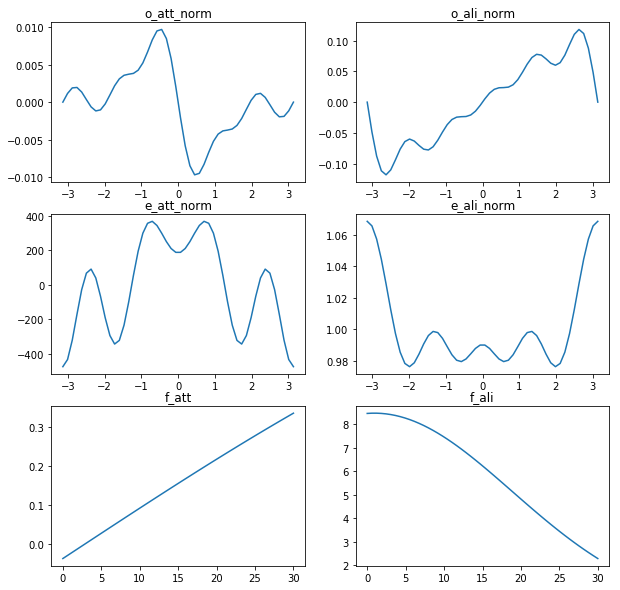

In [19]:
def get_norm_const(function, parameters):
    '''Normalizing factor s.t. square integral over -pi/pi is 1'''
    return 1/(2*np.pi) * quad(lambda a: function(a, *parameters)**2, -np.pi, np.pi)[0]

def eval_norm_func(function, parameters, angles):
    '''Evaluate a normalized angular function.
    Useful for plotting'''
    norm_const = get_norm_const(function, parameters)
    norm_const = 1.0
    return function(angles, *parameters) / norm_const

def get_params_slice(num_fun):
    '''Helper function for social model.
    TODO: Refactor this stuff out.'''
    params = x_opt_social
    offset = 5 + num_fun * num_params
    return params[offset:offset+num_params]

fig, ax = plt.subplots(3,2, figsize=(10,10))
x = np.linspace(-np.pi, np.pi)
#norm_factor = get_norm_const(o_att, get_params_slice(0)) * get_norm_const(e_att, get_params_slice(1))
ax[0][0].plot(x, social_model.o_att(x), label='o_att_norm')
ax[0][0].set_title("o_att_norm")
ax[1][0].plot(x, social_model.e_att(x), label='e_att_norm')
ax[1][0].set_title("e_att_norm")

ax[0][1].plot(x, social_model.o_ali(x), label='o_ali_norm')
ax[0][1].set_title("o_ali_norm")
ax[1][1].plot(x, social_model.e_ali(x), label='e_ali_norm')
ax[1][1].set_title("e_ali_norm")

x = np.linspace(0, 30)
ax[2][0].plot(x, social_model.f_att(x), label='f_att')
ax[2][0].set_title("f_att")
ax[2][1].plot(x, social_model.f_ali(x), label='f_ali')
ax[2][1].set_title("f_ali")

fig.savefig("../../figures/social_5_fourier.pdf", bbox_inches='tight')